# check dataset: MQ2008
- MQ2008: https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/letor-4-0/

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import pathlib

from typing import Any

import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from dataset import mq2008, prepare_lightgbm_dataset
from eval import calc_ndgc_by_model, calc_ndgc

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset: MQ2008

In [3]:
src_path = pathlib.Path("~/Documents/data/MQ2008/Fold1").expanduser()
assert src_path.exists()

dst_path = pathlib.Path("./data/mq2008").resolve()
for dir_path in [*dst_path.parents[::-1], dst_path]:
    if not dir_path.exists():
        dir_path.mkdir()
assert dst_path.exists()

In [4]:
mq2008(src_path, dst_path)

----------------------------------
Characteristics of dataset mq2008 train
rows x columns (9630, 46)
sparsity: 47.22673709874035
y distribution
Counter({0.0: 7820, 1.0: 1223, 2.0: 587})
num samples in queries: minimum, median, maximum
5 8.0 121
----------------------------------
----------------------------------
Characteristics of dataset mq2008 test
rows x columns (2874, 46)
sparsity: 46.112825633112465
y distribution
Counter({0.0: 2319, 1.0: 378, 2.0: 177})
num samples in queries: minimum, median, maximum
6 14.5 119
----------------------------------


## Model: LightGBM LambdaMART

In [5]:
(
    (dtrain, df_train, X_train, y_train, q_train),
    (dval, df_val, X_val, y_val, q_val),
    (dtest, df_test, X_test, y_test, q_test),
) = prepare_lightgbm_dataset(dst_path)

In [6]:
from typing import Optional


def get_params(trial: Optional[optuna.Trial] = None, study: Optional[optuna.Study] = None):
    base_params = {
        # for model
        "boosting_type": "gbdt",
        "objective": "lambdarank",
        "label_gain": "0,1,2",
        # to avoid overfitting
        "learning_rate": 0.1,
        "num_boost_round": 10000,
        "num_leaves": 31,
        "max_depth": -1,
        "min_split_gain": 0.0,
        "min_child_weight": 0.001,
        "min_child_samples": 20,
        "reg_alpha": 0.0,
        "reg_lambda": 0.0,
        # to speed up
        "subsample": 1.0,
        "subsample_freq": 0,
        "colsample_bytree": 1.0,
        # https://robotenique.github.io/posts/gbm-histogram/
        "subsample_for_bin": 200000,
        # for eval
        "metric": "ndcg",
        "eval_at": "10",
        # misc
        "random_state": 1026,
        "n_jobs": -1,
        "saved_feature_importance_type": 0,
        # https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle
        # https://github.com/microsoft/LightGBM/issues/2921
        "use_missing": True,
        "feature_pre_filter": False,
    }

    if trial is not None:
        max_depth = trial.suggest_int("max_depth", 3, 8, step=2)
        num_leaves = trial.suggest_int("num_leaves", 2, int(np.ceil(2**max_depth / 2)), step=2)
        search_params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            "num_leaves": num_leaves,
            "max_depth": max_depth,
            "min_child_samples": trial.suggest_int("min_child_samples", 50, 300, step=10),
            "reg_alpha": trial.suggest_float("reg_alpha", 3e1, 1e2, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e1, 1e2, log=True),
            "subsample": trial.suggest_float("subsample", 0.1, 0.8, step=0.1),
            "subsample_freq": 1,
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 0.8, step=0.1),
        }
        base_params.update(search_params)
    if study is not None:
        base_params.update(study.best_params)

    return base_params


In [7]:
import numpy.typing as npt
from functools import partial


def objective(
    trial: optuna.Trial,
    dtrain: lgb.Dataset,
    dval: lgb.Dataset,
    X_val: npt.NDArray[np.float64],
    y_val: npt.NDArray[np.float64],
    q_val: npt.NDArray[np.int64],
):
    params = get_params(trial)
    pruning_callback = optuna.integration.LightGBMPruningCallback(
        trial, "ndcg@10", valid_name="val"
    )
    early_stopping_callback = lgb.early_stopping(stopping_rounds=10)
    model = lgb.train(
        params=params,
        train_set=dtrain,
        valid_sets=[dval],
        valid_names=["val"],
        callbacks=[early_stopping_callback, pruning_callback],
        early_stopping_rounds=10,
    )

    ndgc = calc_ndgc_by_model(model, X_val, y_val, q_val)
    return ndgc


In [8]:
partial_objective = partial(
    objective, dtrain=dtrain, dval=dval, X_val=X_val, y_val=y_val, q_val=q_val
)
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1026),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=10),
)
study.optimize(partial_objective, n_trials=5000, timeout=600)


[I 2023-06-23 23:02:39,307] A new study created in memory with name: no-name-7a0065eb-7862-4c94-b917-0beacbe2a903
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:02:39,615] Trial 1 finished with value: 0.4763554157630037 and parameters: {'max_depth': 3, 'num_leaves': 4, 'learning_rate': 0.001953914921347611, 'min_child_samples': 190, 'reg_alpha': 46.66469034838938, 'reg_lambda': 45.09519253778812, 'subsample': 0.8, 'colsample_bytree': 0.7000000000000001}. Best is trial 0 with value: 0.4982499584624277.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:39,890] Trial 4 finished with value: 0.331183032064469 and parameters: {'max_depth': 5, 'num_leaves': 2, 'learning_rate': 0.0016700558169201278, 'min_child_samples': 210, 'reg_alpha': 87.37593488222745, 'reg_lambda': 90.08619622616132, 'subsample': 0.4, 'colsample_bytree': 0.4}. Best is trial 0 with value: 0.4982499584624277.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with 

[I 2023-06-23 23:02:40,135] Trial 7 finished with value: 0.48855992925571157 and parameters: {'max_depth': 7, 'num_leaves': 16, 'learning_rate': 0.035808945436235064, 'min_child_samples': 260, 'reg_alpha': 67.29242554970168, 'reg_lambda': 88.50772131801048, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.4982499584624277.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stoppi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-06-23 23:02:40,295] Trial 9 finished with value: 0.331183032064469 and parameters: {'max_depth': 3, 'num_leaves': 2, 'learning_rate': 0.0011874348428440869, 'min_child_samples': 190, 'reg_alpha': 55.8510912974013, 'reg_lambda': 43.617902776760154, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.1}. Best is trial 0 with value: 0.4982499584624277.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005618 seconds

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:40,597] Trial 11 finished with value: 0.4877217337001835 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:40,760] Trial 12 finished with value: 0.4920159042690031 and parameters: {'max_depth': 7, 'num_leaves': 30, 'learning_rate': 0.052160712482885944, 'min_child_samples': 50, 'reg_alpha': 33.98036176930269, 'reg_lambda': 10.268450784997729, 'subsample': 0.6, 'colsample_bytree': 0.2}. Best is trial 0 with value: 0.4982499584624277.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  war

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iter

[I 2023-06-23 23:02:40,928] Trial 13 finished with value: 0.49620806830305714 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.053236787144147785, 'min_child_samples': 110, 'reg_alpha': 39.31327286067115, 'reg_lambda': 13.225662003087123, 'subsample': 0.5, 'colsample_bytree': 0.2}. Best is trial 0 with value: 0.4982499584624277.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until v

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:41,222] Trial 15 finished with value: 0.5009936541532 and 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:02:41,399] Trial 17 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:02:41,500] Trial 18 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:02:41,628] Trial 19 finished with value: 0.49697990330194985 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.009362287220275598, 'min_child_samples': 150, 'reg_alpha': 48.51031355353246, 'reg_lambda': 27.099925159997728, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 15 with value: 0.5009936541532.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[11]	val's ndcg@10: 0.821734
[LightGBM] [Warning] Auto-choosing c

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:41,925] Trial 21 finished with value: 0.5002733817073286 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:42,207] Trial 23 finished with value: 0.5062682198458328 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.04436698644579483, 'min_child_samples': 290, 'reg_alpha': 61.04595619247428, 'reg_lambda': 16.638797627975507, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:02:42,543] Trial 25 finished with value: 0.49814899878573254 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.029670865634111566, 'min_child_samples': 270, 'reg_alpha': 61.87024733222628, 'reg_lambda': 15.757201420238754, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 23 with value: 0.5062682198458328.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:42,674] Trial 26 finished with value: 0.49022795433221034 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:02:42,979] Trial 29 finished with value: 0.49179036041058566 and parameters: {'max_depth': 3, 'num_leaves': 2, 'learning_rate': 0.06345910940608246, 'min_child_samples': 230, 'reg_alpha': 48.435256777799275, 'reg_lambda': 18.526695318768187, 'subsample': 0.4, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:02:43,277] Trial 31 finished with value: 0.49947610175563667 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.08625834516157288, 'min_child_samples': 300, 'reg_alpha': 61.77340275174847, 'reg_lambda': 17.38852525528848, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[21]	val's ndcg@10: 0.827001
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:43,585] Trial 33 finished with value: 0.5005552644116235 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:43,860] Trial 35 pruned. Trial was pruned at iteration 10.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:44,091] Trial 37 finished with value: 0.49955024233378037 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.0350705495860901, 'min_child_samples': 220, 'reg_alpha': 48.99165700113522, 'reg_lambda': 18.982484475241424, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:44,369] Trial 39 pruned. Trial was pruned at iteration 10.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:44,598] Trial 41 finished with value: 0.5006581740353696 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.06528256146770486, 'min_child_samples': 280, 'reg_alpha': 57.73601765197107, 'reg_lambda': 20.95491291862731, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stoppi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:44,891] Trial 43 finished with value: 0.5012811789094928 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:02:45,118] Trial 45 finished with value: 0.5053626104488248 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.0402131568863691, 'min_child_samples': 290, 'reg_alpha': 75.32288145125057, 'reg_lambda': 34.8218486695156, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:02:45,377] Trial 47 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:02:45,479] Trial 48 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:02:45,584] Trial 49 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:02:45,686] Trial 50 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:02:45,796] Trial 51 pruned. Trial was pruned at iteration 18.
[I 2023-06-23 23:02:45,919] Trial 52 finished with value: 0.49607387245740114 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.05238263539982795, 'min_child_samples': 290, 'reg_alpha': 66.21474545857647, 'reg_lambda': 22.999894577256324, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 23 with value: 0.5062682198458328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:46,075] Trial 53 pruned. Trial was pruned at iteration 10.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:46,225] Trial 54 finished with value: 0.4967827761519513 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.03937918764317077, 'min_child_samples': 80, 'reg_alpha': 54.44378049115344, 'reg_lambda': 16.25191282933647, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:02:46,528] Trial 56 finished with value: 0.5030659652090458 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.07346784358514667, 'min_child_samples': 180, 'reg_alpha': 64.61397648336485, 'reg_lambda': 15.344280437785248, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:46,934] Trial 58 pruned. Trial was pruned at iteration 10.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:02:47,238] Trial 59 finished with value: 0.5009492874153046 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.013030465805717737, 'min_child_samples': 70, 'reg_alpha': 68.77665023089308, 'reg_lambda': 15.293665181418822, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:47,341] Trial 60 pruned. Trial was pruned at iteration 10.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:47,572] Trial 61 finished with value: 0.500130148934274 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.013072104789978448, 'min_child_samples': 70, 'reg_alpha': 68.09857936553654, 'reg_lambda': 15.156194227681452, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:47,739] Trial 62 finished with value: 0.49814864551651883 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:48,175] Trial 65 finished with value: 0.49958664765545024 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.09695634063216238, 'min_child_samples': 90, 'reg_alpha': 68.41319881653307, 'reg_lambda': 18.0518846046544, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:48,322] Trial 66 pruned. Trial was pruned at iteration 11.
[I 2023-06-23 23:02:48,480] Trial 67 finished with value: 0.5021388936707739 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.024399204666048318, 'min_child_samples': 300, 'reg_alpha': 60.5454588618813, 'reg_lambda': 14.213756949719022, 'su

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:48,622] Trial 68 pruned. Trial was pruned at iteration 10.

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:48,869] Trial 70 pruned. Trial was pruned at iteration 10.

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:02:49,166] Trial 72 finished with value: 0.5005773832137791 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.026072687386064983, 'min_child_samples': 290, 'reg_alpha': 60.86754787358305, 'reg_lambda': 13.351665954751644, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:49,343] Trial 73 finished with value: 0.5037398219398204 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.038354624346113246, 'min_child_samples': 60, 'reg_alpha': 62.22886756495148, 'reg_lambda': 14.348660306467863, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-06-23 23:02:49,557] Trial 75 pruned. Trial was pruned at iteration 20.
[I 2023-06-23 23:02:49,682] Trial 76 finished with value: 0.4968312616032301 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.030467660455470957, 'min_child_samples': 240, 'reg_alpha': 60.5196026675312, 'reg_lambda': 16.93436411135446, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 23 with value: 0.5062682198458328.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:49,872] Trial 77 finished with value: 0.4997920857915132 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:50,103] Trial 78 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:02:50,248] Trial 79 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:02:50,352] Trial 80 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:02:50,472] Trial 81 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:50,655] Trial 82 finished with value: 0.5005653646698991 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.04341716545321641, 'min_child_samples': 70, 'reg_alpha': 68.08979508633571, 'reg_lambda': 14.057914663215124, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stoppi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:51,084] Trial 85 finished with value: 0.49979071561270855 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.08766454770381217, 'min_child_samples': 160, 'reg_alpha': 69.75039773899583, 'reg_lambda': 14.73444659445241, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 23 with v

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:02:51,274] Trial 86 finished with value: 0.501052707175611 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.039140547747921, 'min_child_samples': 60, 'reg_alpha': 62.784977885066745, 'reg_lambda': 12.845863270802294, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-06-23 23:02:51,490] Trial 88 pruned. Trial was pruned at iteration 11.
[I 2023-06-23 23:02:51,623] Trial 89 finished with value: 0.4976320500920862 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.06160914065806023, 'min_child_samples': 60, 'reg_alpha': 64.64298432842874, 'reg_lambda': 13.86062316063009, 'subsample': 0.6, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:51,767] Trial 90 pruned. Trial was pruned at iteration 10.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:52,094] Trial 92 finished with value: 0.5022164740970908 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:52,303] Trial 93 finished with value: 0.49876611353936684 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03616527053247085, 'min_child_samples': 60, 'reg_alpha': 57.193638443003756, 'reg_lambda': 16.450303215049235, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.506268

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requireme

[I 2023-06-23 23:02:52,537] Trial 95 finished with value: 0.4999056018513103 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.03911881709791862, 'min_child_samples': 80, 'reg_alpha': 59.59940408813094, 'reg_lambda': 18.054500080108294, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning:

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:02:52,817] Trial 97 finished with value: 0.5025404392991079 and parameters: {'max_depth': 5, 'num_leaves': 16, 'learning_rate': 0.04565949055896663, 'min_child_samples': 60, 'reg_alpha': 62.59959467420832, 'reg_lambda': 12.551015791677184, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:53,045] Trial 98 pruned. Trial was pruned at iteration 10.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:53,363] Trial 100 finished with value: 0.5025626340637447 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:53,540] Trial 101 finished with value: 0.5017560368017698 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.04416047496173775, 'min_child_samples': 280, 'reg_alpha': 61.93214478004452, 'reg_lambda': 12.313508197353581, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[14]	val's ndcg@10: 0.829957
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits wi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:53,865] Trial 103 finished with value: 0.501069690536849 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:54,051] Trial 104 finished with value: 0.5024049216118737 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.045392679984224374, 'min_child_samples': 280, 'reg_alpha': 61.599593921462485, 'reg_lambda': 12.508695962552883, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_st

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can se

[I 2023-06-23 23:02:54,213] Trial 105 finished with value: 0.5020526429749117 and parameters: {'max_depth': 5, 'num_leaves': 16, 'learning_rate': 0.06674897900716026, 'min_child_samples': 280, 'reg_alpha': 58.025503148967644, 'reg_lambda': 11.152129334598698, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:54,563] Trial 107 finished with value: 0.49884540936919564 and parameters: {'max_depth': 5, 'num_leaves': 16, 'learning_rate': 0.04475980385601807, 'min_child_samples': 260, 'reg_alpha': 61.87033084037765, 'reg_lambda': 11.268988254558856, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warn

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:54,865] Trial 109 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:55,102] Trial 111 finished with value: 0.5035698278108586 and parameters: {'max_depth': 5, 'num_leaves': 16, 'learning_rate': 0.048622090260714464, 'min_child_samples': 280, 'reg_alpha': 59.83538121668429, 'reg_lambda': 12.234268446644002, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:55,292] Trial 112 finished with value: 0.5016776885372164 and parameters: {'max_depth': 5, 'num_leaves': 16, 'learning_rate': 0.05184148340252298, 'min_child_samples': 250, 'reg_alpha': 59.45181780910853, 'reg_lambda': 12.007061580056392, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.506268

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:55,471] Trial 113 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:02:55,579] Trial 114 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:02:55,696] Trial 115 pruned. Trial was pruned at iteration 20.
[I 2023-06-23 23:02:55,803] Trial 116 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:02:55,995] Trial 117 finished with value: 0.5021577392743832 and parameters: {'max_depth': 5, 'num_leaves': 16, 'learning_rate': 0.06538236146792568, 'min_child_samples': 280, 'reg_alpha': 64.96884552548296, 'reg_lambda': 10.670216511903966, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:56,149] Trial 118 pruned. Trial was pruned at iteration 20.
[I 2023-06-23 23:02:56,273] Trial 119 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warn

[I 2023-06-23 23:02:56,411] Trial 120 finished with value: 0.5009052401185167 and parameters: {'max_depth': 5, 'num_leaves': 16, 'learning_rate': 0.05319156027500912, 'min_child_samples': 260, 'reg_alpha': 62.92500898805908, 'reg_lambda': 11.679228554406707, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:56,606] Trial 121 finished with value: 0.49932263846134306 and parameters: {'max_depth': 5, 'num_leaves': 16, 'learning_rate': 0.06603291013362851, 'min_child_samples': 270, 'reg_alpha': 57.93137506118351, 'reg_lambda': 11.101584305299266, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.50626

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-06-23 23:02:56,793] Trial 122 finished with value: 0.5016161130482985 and parameters: {'max_depth': 5, 'num_leaves': 16, 'learning_rate': 0.04130529359098684, 'min_child_samples': 280, 'reg_alpha': 60.28618114820893, 'reg_lambda': 10.453446128985712, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[13]	val's ndcg@10: 0.828656
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:57,111] Trial 124 finished with value: 0.4996672523652067 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:57,291] Trial 125 finished with value: 0.5014954761157612 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.08182035062426692, 'min_child_samples': 290, 'reg_alpha': 63.73095384963763, 'reg_lambda': 12.274706713972673, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.828663
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation s

[I 2023-06-23 23:02:57,629] Trial 127 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:02:57,783] Trial 128 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:02:57,910] Trial 129 finished with value: 0.4985383955094609 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.06180099016087142, 'min_child_samples': 190, 'reg_alpha': 59.485610057441725, 'reg_lambda': 10.611486091052567, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:58,088] Trial 130 finished with value: 0.5005793238360496 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:58,225] Trial 131 finished with value: 0.5027395373120063 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.045764757362385555, 'min_child_samples': 280, 'reg_alpha': 61.78518823742051, 'reg_lambda': 11.970171335590036, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:02:58,580] Trial 133 finished with value: 0.4997431396054092 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03845773963358697, 'min_child_samples': 270, 'reg_alpha': 65.53989800904138, 'reg_lambda': 13.848220810114334, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[I 2023-06-23 23:02:58,729] Trial 134 finished with value: 0.5032966084311484 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.041525911984877456, 'min_child_samples': 290, 'reg_alpha': 62.72836732714496, 'reg_lambda': 14.725903428161232, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:59,213] Trial 137 finished with value: 0.5039197454985631 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:02:59,455] Trial 139 finished with value: 0.505455060829614 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03263552985958417, 'min_child_samples': 290, 'reg_alpha': 69.28594307914106, 'reg_lambda': 12.82444139337326, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 23 with value: 0.5062682198458328.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:02:59,630] Trial 140 finished with value: 0.5055423783841015 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03128553239243503, 'min_child_samples': 290, 'reg_alpha': 69.03884583120175, 'reg_lambda': 12.84403584514194, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 23 with value: 0.5062682

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:00,071] Trial 143 pruned. Trial was pruned at iteration 11.
[I 2023-06-23 23:03:00,177] Trial 144 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:00,288] Trial 145 pruned. Trial was pruned at iteration 11.
[I 2023-06-23 23:03:00,396] Trial 146 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:00,549] Trial 147 finished with value: 0.5102088874603314 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.042762889182301096, 'min_child_samples': 290, 'reg_alpha': 62.279396620361986, 'reg_lambda': 13.423115029106718, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_s

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:00,790] Trial 149 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:03:00,925] Trial 150 finished with value: 0.5083031576314362 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03402295564615259, 'min_child_samples': 290, 'reg_alpha': 62.099686269440426, 'reg_lambda': 13.037671157520839, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:01,107] Trial 151 finished with value: 0.5060051440991845 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:01,355] Trial 153 pruned. Trial was pruned at iteration 11.
[I 2023-06-23 23:03:01,491] Trial 154 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:01,627] Trial 155 finished with value: 0.5040386871517908 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.038654299332008396, 'min_child_samples': 290, 'reg_alpha': 69.42374207997133, 'reg_lambda': 11.938282965742562, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:01,817] Trial 156 finished with value: 0.49764260912062025 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03902426681247856, 'min_child_samples': 300, 'reg_alpha': 69.31315904803137, 'reg_lambda': 11.783951812620836, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning

[I 2023-06-23 23:03:02,005] Trial 157 finished with value: 0.5009415542765471 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.034229728568727004, 'min_child_samples': 290, 'reg_alpha': 67.74118170381166, 'reg_lambda': 14.145866466654097, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_st

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:02,475] Trial 160 finished with value: 0.5028030976506328 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03674118636066974, 'min_child_samples': 290, 'reg_alpha': 64.61342131491116, 'reg_lambda': 12.178209862509046, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:02,665] Trial 161 finished with value: 0.501914732780462 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03635769982741106, 'min_child_samples': 290, 'reg_alpha': 64.6457914805646, 'reg_lambda': 12.09927193687748, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.51020888

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:02,849] Trial 162 finished with value: 0.5083031576314362 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03301632747800233, 'min_child_samples': 290, 'reg_alpha': 61.8096828590919, 'reg_lambda': 13.436643180157814, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:03:03,257] Trial 165 finished with value: 0.499569150846356 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03729272079063886, 'min_child_samples': 290, 'reg_alpha': 70.54492560213401, 'reg_lambda': 14.313450041682511, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:03,394] Trial 166 finished with value: 0.49882837606997005 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.03439458805911375, 'min_child_samples': 280, 'reg_alpha': 64.20397089846561, 'reg_lambda': 12.11986337861245, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.51020

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.824043
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:03,685] Trial 168 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:03,992] Trial 170 finished with value: 0.5035323870967239 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:04,179] Trial 171 finished with value: 0.5051497946009135 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.031466610776141234, 'min_child_samples': 280, 'reg_alpha': 68.35246281427418, 'reg_lambda': 11.708185357114667, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.82257


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:04,432] Trial 172 finished with value: 0.5051497946009135 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03137071262108589, 'min_child_samples': 280, 'reg_alpha': 68.19913586134554, 'reg_lambda': 11.487626831258213, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.51020

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:04,574] Trial 173 finished with value: 0.4995564550624241 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.024886572138188554, 'min_child_samples': 270, 'reg_alpha': 69.3975235325655, 'reg_lambda': 11.32643189090624, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:04,974] Trial 176 finished with value: 0.5078130357177787 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.031272697800906815, 'min_child_samples': 280, 'reg_alpha': 70.5797605981365, 'reg_lambda': 14.132814616297887, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:05,251] Trial 177 finished with value: 0.5011777136527044 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.031477362479201854, 'min_child_samples': 280, 'reg_alpha': 74.66152827535544, 'reg_lambda': 12.892732867637221, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:05,398] Trial 178 finished with value: 0.49866832744171785 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.022003893560719637, 'min_child_samples': 270, 'reg_alpha': 69.78980252249056, 'reg_lambda': 13.95816250868289, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:05,573] Trial 179 finished with value: 0.5037996862655342 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.026529141338659825, 'min_child_samples': 260, 'reg_alpha': 67.32082604276788, 'reg_lambda': 34.830113259675, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:05,883] Trial 181 finished with value: 0.5004964747855248 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.030174254522525985, 'min_child_samples': 270, 'reg_alpha': 67.87814567000494, 'reg_lambda': 14.496422127357794, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:06,073] Trial 182 finished with value: 0.5015974889917083 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03495562565974584, 'min_child_samples': 280, 'reg_alpha': 66.91279110421482, 'reg_lambda': 13.448698246901944, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.51020

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.82611
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-06-23 23:03:06,258] Trial 183 finished with value: 0.5007316058825285 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.033275930897037634, 'min_child_samples': 290, 'reg_alpha': 69.61124900005122, 'reg_lambda': 37.37131627377239, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:06,657] Trial 185 finished with value: 0.502437394285526 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.028846037003766846, 'min_child_samples': 270, 'reg_alpha': 73.54637267094319, 'reg_lambda': 12.615069281433163, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:03:06,954] Trial 187 finished with value: 0.5056233283189948 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03862551888940242, 'min_child_samples': 290, 'reg_alpha': 67.26922790170732, 'reg_lambda': 11.803496086023413, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:07,147] Trial 188 finished with value: 0.5007550788698591 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.825436
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:07,330] Trial 189 finished with value: 0.5031773761016789 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.020021919818339666, 'min_child_samples': 280, 'reg_alpha': 70.51133859530563, 'reg_lambda': 11.865601734086152, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.51020

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:07,683] Trial 191 finished with value: 0.5034606405705196 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0405932400749253, 'min_child_samples': 290, 'reg_alpha': 66.45796949789873, 'reg_lambda': 13.267851978921096, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 147 with value: 0.5102088874603314.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555

[I 2023-06-23 23:03:07,855] Trial 192 finished with value: 0.511825654472031 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.030794553494331637, 'min_child_samples': 290, 'reg_alpha': 66.91805356457729, 'reg_lambda': 12.321034257370249, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:08,233] Trial 194 finished with value: 0.502130604626113 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.026491418390061576, 'min_child_samples': 290, 'reg_alpha': 65.62430839478272, 'reg_lambda': 12.51951223163709, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.824042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

[I 2023-06-23 23:03:08,413] Trial 195 finished with value: 0.503651446235004 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.02934760212264946, 'min_child_samples': 290, 'reg_alpha': 67.53595639120465, 'reg_lambda': 12.16746531454575, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stoppi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:08,852] Trial 197 finished with value: 0.4969608439771746 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.027864455489536318, 'min_child_samples': 300, 'reg_alpha': 72.05418981984518, 'reg_lambda': 13.125251796589817, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.821395
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001898 seconds.
You c

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:09,024] Trial 198 pruned. Trial was pruned at iteration 18.
[I 2023-06-23 23:03:09,174] Trial 199 finished with value: 0.49944930267351306 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.034464026842951745, 'min_child_samples': 300, 'reg_alpha': 74.22274204986327, 'reg_lambda': 13.86935046968424, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:09,372] Trial 200 finished with value: 0.5055117327396375 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:09,571] Trial 201 finished with value: 0.5055423783841015 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.031050119357728646, 'min_child_samples': 290, 'reg_alpha': 68.79423327850074, 'reg_lambda': 19.21558902174417, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.8255
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, n

[I 2023-06-23 23:03:09,760] Trial 202 finished with value: 0.49947227067788336 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.031997589388149034, 'min_child_samples': 290, 'reg_alpha': 70.61970106700862, 'reg_lambda': 19.084130827648167, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_st

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:10,083] Trial 204 finished with value: 0.5053011523917699 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:10,280] Trial 205 finished with value: 0.5000213740511771 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03603599754070876, 'min_child_samples': 300, 'reg_alpha': 72.60898303698808, 'reg_lambda': 20.332911330783716, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:10,543] Trial 206 finished with value: 0.505754748458246 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.034006653942423755, 'min_child_samples': 300, 'reg_alpha': 69.71343239836831, 'reg_lambda': 19.391307528950872, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:10,737] Trial 207 finished with value: 0.5024592594391617 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03264171030378334, 'min_child_samples': 300, 'reg_alpha': 70.2249589841353, 'reg_lambda': 19.583981153989182, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:10,936] Trial 208 finished with value: 0.5060232213875161 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03639690236762745, 'min_child_samples': 300, 'reg_alpha': 69.29823292094589, 'reg_lambda': 20.956630605233684, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped train

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:11,149] Trial 209 finished with value: 0.5015929106890138 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.036964550822355245, 'min_child_samples': 300, 'reg_alpha': 71.46891861481537, 'reg_lambda': 20.589586055467347, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.5118

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.824763
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with p

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:11,302] Trial 210 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:03:11,469] Trial 211 finished with value: 0.5011628561573346 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03114376453173408, 'min_child_samples': 300, 'reg_alpha': 75.18233680955618, 'reg_lambda': 18.38157924766266, 's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:11,691] Trial 212 finished with value: 0.50562321515705 an

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:11,872] Trial 213 finished with value: 0.5063989559400321 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:12,088] Trial 214 finished with value: 0.5022959002987779 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03622414687259083, 'min_child_samples': 300, 'reg_alpha': 71.1863175176623, 'reg_lambda': 21.278523897265114, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:12,381] Trial 215 finished with value: 0.5024602415186444 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03245112211970802, 'min_child_samples': 290, 'reg_alpha': 69.05592928697976, 'reg_lambda': 22.17551804749031, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:12,585] Trial 216 finished with value: 0.5004452053406936 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.042763218604725, 'min_child_samples': 300, 'reg_alpha': 72.99739629098148, 'reg_lambda': 19.189805848510396, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.5118256

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:12,787] Trial 217 finished with value: 0.5003841121591055 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.038615546147089036, 'min_child_samples': 290, 'reg_alpha': 70.878597261572, 'reg_lambda': 20.056333782536466, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:12,998] Trial 218 finished with value: 0.5022938942514708 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03553124676401668, 'min_child_samples': 290, 'reg_alpha': 73.01381669029453, 'reg_lambda': 17.634354736817112, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:13,204] Trial 219 finished with value: 0.505321148750668 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03302962936392996, 'min_child_samples': 300, 'reg_alpha': 68.42280698489499, 'reg_lambda': 23.52997380277733, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.5118256

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:13,418] Trial 220 finished with value: 0.49697788644156293 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.04372694974119589, 'min_child_samples': 300, 'reg_alpha': 69.42207600357513, 'reg_lambda': 21.48704462441441, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:13,732] Trial 221 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:03:13,933] Trial 222 finished with value: 0.49858290401101085 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.02954101132195225, 'min_child_samples': 290, 'reg_alpha': 66.57340473636846, 'reg_lambda': 23.572982695215916, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:14,154] Trial 223 finished with value: 0.5029091841270278 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:14,413] Trial 224 finished with value: 0.5001122588365258 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:14,625] Trial 225 finished with value: 0.4996272774544754 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:14,855] Trial 226 finished with value: 0.5050635511447579 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:15,218] Trial 227 finished with value: 0.5040621394665852 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:15,445] Trial 228 finished with value: 0.499226936333025 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03283211997784527, 'min_child_samples': 300, 'reg_alpha': 74.32115284467511, 'reg_lambda': 18.707107141750186, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:15,696] Trial 229 finished with value: 0.503321984708423 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.042053219004751737, 'min_child_samples': 280, 'reg_alpha': 69.761840367883, 'reg_lambda': 25.0645563928617, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:15,968] Trial 230 finished with value: 0.5023684787051129 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.029625398798286028, 'min_child_samples': 300, 'reg_alpha': 66.99372414488647, 'reg_lambda': 19.788199517995686, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.5118

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:16,232] Trial 231 finished with value: 0.502698716020697 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.026997940098956258, 'min_child_samples': 290, 'reg_alpha': 67.93852656859823, 'reg_lambda': 21.255809893230087, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:16,494] Trial 232 finished with value: 0.505893226227372 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03554053755298308, 'min_child_samples': 290, 'reg_alpha': 68.86007863774827, 'reg_lambda': 20.595598889957525, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:16,804] Trial 233 finished with value: 0.5053011523917699 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03554707971718937, 'min_child_samples': 290, 'reg_alpha': 70.20561315376604, 'reg_lambda': 18.028812832874237, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:17,244] Trial 234 finished with value: 0.5003950664028715 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03816054382837087, 'min_child_samples': 290, 'reg_alpha': 69.7050742595296, 'reg_lambda': 17.729742220565527, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:17,557] Trial 235 finished with value: 0.4995014062163842 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:17,843] Trial 236 finished with value: 0.49765018051281956

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:18,149] Trial 237 finished with value: 0.4980524617433632 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:18,430] Trial 238 finished with value: 0.5006924608502833 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:18,751] Trial 239 finished with value: 0.5027120465467461 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:19,161] Trial 240 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:19,412] Trial 241 finished with value: 0.500634225925154 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03152935003521024, 'min_child_samples': 280, 'reg_alpha': 68.27638583918537, 'reg_lambda': 19.350017323171283, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:19,691] Trial 242 finished with value: 0.5017773061123258 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:19,969] Trial 243 finished with value: 0.4954084057568692 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:20,288] Trial 244 finished with value: 0.504091904174025 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:20,571] Trial 245 finished with value: 0.50120212551055 an

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:20,885] Trial 246 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:21,248] Trial 247 finished with value: 0.5024875618293928 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.032522356296188625, 'min_child_samples': 300, 'reg_alpha': 69.34538707236864, 'reg_lambda': 23.537994604589013, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:21,541] Trial 248 finished with value: 0.4978251418334095 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:21,836] Trial 249 finished with value: 0.5035029348146082 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:22,123] Trial 250 finished with value: 0.5015890854902448 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:22,383] Trial 251 finished with value: 0.49932559597031584

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:22,822] Trial 252 finished with value: 0.5006041256674013 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:23,006] Trial 253 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:03:23,211] Trial 254 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the trai

[I 2023-06-23 23:03:23,513] Trial 255 finished with value: 0.5042101999231074 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0338498114576043, 'min_child_samples': 300, 'reg_alpha': 69.22280599284083, 'reg_lambda': 17.341967918501407, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:23,776] Trial 256 finished with value: 0.4999198107109693 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:24,145] Trial 257 finished with value: 0.5075996539614271 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.030022770711833707, 'min_child_samples': 280, 'reg_alpha': 63.991348327943165, 'reg_lambda': 26.758954407355365, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_st

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:24,515] Trial 259 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:24,810] Trial 260 finished with value: 0.507405044967012 and parameters: {'max_depth': 7, 'num_leaves': 18, 'learning_rate': 0.022325953813660298, 'min_child_samples': 290, 'reg_alpha': 65.54995582261189, 'reg_lambda': 27.15033895785484, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:25,095] Trial 261 finished with value: 0.501976689711708 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:25,355] Trial 262 finished with value: 0.4969781159609056 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:25,544] Trial 263 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:25,886] Trial 264 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:26,124] Trial 265 finished with value: 0.5043644842756086 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.027447625713608873, 'min_child_samples': 300, 'reg_alpha': 65.8373476360439, 'reg_lambda': 27.041723979147946, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:26,313] Trial 266 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:26,517] Trial 267 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[Ligh

[I 2023-06-23 23:03:26,720] Trial 268 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-06-23 23:03:26,949] Trial 269 finished with value: 0.505006780261574 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.04216094219826738, 'min_child_samples': 280, 'reg_alpha': 63.28009494433901, 'reg_lambda': 27.8575768367501, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:27,165] Trial 270 finished with value: 0.5016893009549372 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:27,418] Trial 271 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:03:27,690] Trial 272 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:03:27,917] Trial 273 finished with value: 0.5017588164974771 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03851341004636905, 'min_child_samples': 300, 'reg_alpha': 65.57811251958472, 'reg_lambda': 24.193490950108057, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:28,126] Trial 274 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:28,346] Trial 275 finished with value: 0.4967226134271949 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.02594490238799935, 'min_child_samples': 290, 'reg_alpha': 63.48984356657043, 'reg_lambda': 25.649688354396726, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:28,558] Trial 276 finished with value: 0.5005702688270824 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:28,874] Trial 277 finished with value: 0.49220623611209746

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:29,070] Trial 278 finished with value: 0.50001579398596 an

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:29,275] Trial 279 finished with value: 0.4999826631700782 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.04114393364208506, 'min_child_samples': 290, 'reg_alpha': 69.66197018604221, 'reg_lambda': 21.460195066081862, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:29,476] Trial 280 finished with value: 0.5048049975847212 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0329767731786702, 'min_child_samples': 300, 'reg_alpha': 66.91654887528965, 'reg_lambda': 32.413061116597476, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-06-23 23:03:29,636] Trial 281 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:03:29,769] Trial 282 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-06-23 23:03:29,967] Trial 283 finished with value: 0.5011824775850094 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.05000468884012561, 'min_child_samples': 300, 'reg_alpha': 59.227287505220154, 'reg_lambda': 21.057479361681175, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:30,375] Trial 284 finished with value: 0.49907108067485767 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.04331051418847685, 'min_child_samples': 290, 'reg_alpha': 68.56315857983066, 'reg_lambda': 51.81720990852528, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:30,597] Trial 285 finished with value: 0.5016856083260984 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:30,804] Trial 286 finished with value: 0.500256177835464 a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:31,016] Trial 287 finished with value: 0.5100563495769017 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:31,176] Trial 288 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:03:31,615] Trial 290 finished with value: 0.5014595524183334 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.003591097367933275, 'min_child_samples': 280, 'reg_alpha': 72.40872858678014, 'reg_lambda': 22.435691453140596, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:31,799] Trial 291 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:32,048] Trial 292 finished with value: 0.5030990457274817 and parameters: {'max_depth': 7, 'num_leaves': 48, 'learning_rate': 0.0019749305712234424, 'min_child_samples': 290, 'reg_alpha': 63.22890234120301, 'reg_lambda': 21.45848532762786, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:32,325] Trial 293 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:03:32,527] Trial 294 finished with value: 0.4970082859014977 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0191698360409911, 'min_child_samples': 300, 'reg_alpha': 68.79362469659594, 'reg_lambda': 25.736912808181927, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:32,713] Trial 295 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-06-23 23:03:32,996] Trial 296 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:03:33,212] Trial 297 finished with value: 0.5036216583952478 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.027015512443328792, 'min_child_samples': 290, 'reg_alpha': 70.21113881214285, 'reg_lambda': 23.571809405343416, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.824127


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:33,421] Trial 298 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:33,642] Trial 299 finished with value: 0.5045864125836366 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0033956487076291443, 'min_child_samples': 290, 'reg_alpha': 44.07858008371188, 'reg_lambda': 22.085441906479893, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:33,838] Trial 300 finished with value: 0.504720564537503 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:34,051] Trial 301 finished with value: 0.5048641659673817 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.018293563246167436, 'min_child_samples': 290, 'reg_alpha': 68.98886233586742, 'reg_lambda': 14.05853045905485, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:34,357] Trial 302 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:34,557] Trial 303 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:34,755] Trial 304 finished with value: 0.5038293503483305 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.021922924021269736, 'min_child_samples': 290, 'reg_alpha': 40.89906067906597, 'reg_lambda': 19.228058988378052, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 se

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:34,974] Trial 305 finished with value: 0.4967338270378015 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03093001188499664, 'min_child_samples': 300, 'reg_alpha': 49.405961588587935, 'reg_lambda': 15.672583230521592, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 192 wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:35,201] Trial 306 finished with value: 0.49899281427310155 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.024635408372727204, 'min_child_samples': 280, 'reg_alpha': 58.33736145597653, 'reg_lambda': 14.779297829638574, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:35,372] Trial 307 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:03:35,652] Trial 308 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:35,846] Trial 309 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Train

[I 2023-06-23 23:03:36,054] Trial 310 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning

[I 2023-06-23 23:03:36,280] Trial 311 finished with value: 0.4998018514194665 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0015111814780750389, 'min_child_samples': 270, 'reg_alpha': 69.13869763673144, 'reg_lambda': 12.393925773575125, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if mem

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:36,461] Trial 312 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the trai

[I 2023-06-23 23:03:36,808] Trial 313 finished with value: 0.5036976590317622 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0014582527111859339, 'min_child_samples': 280, 'reg_alpha': 70.67915194881975, 'reg_lambda': 21.407416778579417, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[11]	val's ndcg@10: 0.826567


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:36,998] Trial 314 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:37,214] Trial 315 finished with value: 0.503356370161525 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.0276112040276904, 'min_child_samples': 290, 'reg_alpha': 64.36030223584966, 'reg_lambda': 13.589517815861695, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:37,424] Trial 316 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-06-23 23:03:37,636] Trial 317 finished with value: 0.4949472325527181 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.04483045211914632, 'min_child_samples': 290, 'reg_alpha': 73.23240372618079, 'reg_lambda': 17.080990962885163, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:37,954] Trial 318 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:38,127] Trial 319 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:03:38,341] Trial 320 finished with value: 0.5035679675298218 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.050772687634991966, 'min_child_samples': 300, 'reg_alpha': 53.941597213143716, 'reg_lambda': 80.24891422532143, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.821776
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:38,575] Trial 321 finished with value: 0.501968991396989 a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:38,771] Trial 322 finished with value: 0.5024953534634263 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:39,087] Trial 323 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:03:39,384] Trial 324 finished with value: 0.5053447306613784 and parameters: {'max_depth': 7, 'num_leaves': 20, 'learning_rate': 0.03497649485195519, 'min_child_samples': 270, 'reg_alpha': 31.006359456496018, 'reg_lambda': 34.58955263585366, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:39,613] Trial 325 finished with value: 0.49993549528004466

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:39,806] Trial 326 pruned. Trial was pruned at iteration 21

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:40,045] Trial 327 finished with value: 0.4983103662220124 and parameters: {'max_depth': 7, 'num_leaves': 18, 'learning_rate': 0.01019437742973763, 'min_child_samples': 280, 'reg_alpha': 60.7351143409683, 'reg_lambda': 12.179583359189479, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:40,367] Trial 328 finished with value: 0.5084561390024535 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:40,583] Trial 329 finished with value: 0.503862756630566 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:40,801] Trial 330 finished with value: 0.5027233961718434 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:41,006] Trial 331 finished with value: 0.5013841614246355 

[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:41,202] Trial 332 finished with value: 0.5028311225399608 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:41,491] Trial 333 finished with value: 0.4962940375435257 and parameters: {'max_depth': 7, 'num_leaves': 18, 'learning_rate': 0.03532779060919018, 'min_child_samples': 210, 'reg_alpha': 33.90308863603319, 'reg_lambda': 35.0933726322786, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.5118256

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:41,788] Trial 334 finished with value: 0.4981980116409636 and parameters: {'max_depth': 7, 'num_leaves': 18, 'learning_rate': 0.002289676132760723, 'min_child_samples': 270, 'reg_alpha': 38.66270846746795, 'reg_lambda': 33.96924237768944, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 192 with

Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:41,995] Trial 335 finished with value: 0.5031725778094189 and parameters: {'max_depth': 7, 'num_leaves': 24, 'learning_rate': 0.045000533125899425, 'min_child_samples': 280, 'reg_alpha': 41.781478878919785, 'reg_lambda': 37.770251204063555, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:42,215] Trial 336 finished with value: 0.5030393725868033 and parameters: {'max_depth': 7, 'num_leaves': 10, 'learning_rate': 0.0012700547277696265, 'min_child_samples': 290, 'reg_alpha': 31.042484633877724, 'reg_lambda': 39.82108305802287, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:42,386] Trial 337 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:42,702] Trial 338 finished with value: 0.5057802369183256 and parameters: {'max_depth': 7, 'num_leaves': 34, 'learning_rate': 0.030743125886178092, 'min_child_samples': 290, 'reg_alpha': 63.75478091566894, 'reg_lambda': 14.041346390818518, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:42,944] Trial 339 finished with value: 0.5023994924515741 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:43,178] Trial 340 finished with value: 0.4950141130212862 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:43,358] Trial 341 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:43,571] Trial 342 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Train

[I 2023-06-23 23:03:43,956] Trial 343 finished with value: 0.5028197409398066 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.002272175582972513, 'min_child_samples': 290, 'reg_alpha': 59.30236320878435, 'reg_lambda': 12.682264878138575, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:03:44,365] Trial 345 finished with value: 0.4997789071736661 and parameters: {'max_depth': 7, 'num_leaves': 34, 'learning_rate': 0.032481991618688665, 'min_child_samples': 290, 'reg_alpha': 32.787196881696346, 'reg_lambda': 14.978994684616962, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:44,658] Trial 346 finished with value: 0.5012995254121415 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:44,862] Trial 347 finished with value: 0.4926795135442312 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:45,055] Trial 348 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:03:45,384] Trial 349 finished with value: 0.49753796973903813 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.09085585817555862, 'min_child_samples': 300, 'reg_alpha': 44.524738911626756, 'reg_lambda': 19.173807251746247, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:45,578] Trial 350 finished with value: 0.508018781128816 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:45,858] Trial 351 finished with value: 0.499635880580857 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.017072282421632133, 'min_child_samples': 190, 'reg_alpha': 50.32940805398272, 'reg_lambda': 16.849191718965827, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:46,097] Trial 352 finished with value: 0.49947142595738897 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.017862677265203283, 'min_child_samples': 280, 'reg_alpha': 65.62899218740941, 'reg_lambda': 16.16105261144101, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:46,274] Trial 353 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:46,608] Trial 354 finished with value: 0.5054204107111177 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.005842259845483021, 'min_child_samples': 280, 'reg_alpha': 45.69732788339128, 'reg_lambda': 17.77680108847979, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:46,776] Trial 355 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits wit

[I 2023-06-23 23:03:46,969] Trial 356 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:47,199] Trial 357 finished with value: 0.49771232166353446 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.03134320699918177, 'min_child_samples': 280, 'reg_alpha': 43.25589936984224, 'reg_lambda': 12.521401426811542, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:47,463] Trial 358 finished with value: 0.49370171683616193

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:47,830] Trial 359 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:48,070] Trial 360 finished with value: 0.5010810408408539 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.004330729701433938, 'min_child_samples': 290, 'reg_alpha': 63.1806483848662, 'reg_lambda': 11.194468930732377, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:48,257] Trial 361 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:03:48,514] Trial 362 finished with value: 0.5019318615722654 and parameters: {'max_depth': 7, 'num_leaves': 16, 'learning_rate': 0.019263188867317954, 'min_child_samples': 280, 'reg_alpha': 60.497553506317736, 'reg_lambda': 43.8003400719741, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:48,850] Trial 363 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:49,027] Trial 364 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:03:49,236] Trial 365 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:03:49,422] Trial 366 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:49,671] Trial 367 finished with value: 0.4993832152878171 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.008412342588542064, 'min_child_samples': 300, 'reg_alpha': 55.82529444743551, 'reg_lambda': 12.14030370293427, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:49,960] Trial 368 finished with value: 0.5032768178725124 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:50,149] Trial 369 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:50,363] Trial 370 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555

[I 2023-06-23 23:03:50,633] Trial 371 finished with value: 0.5030097109524737 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.001038613183286433, 'min_child_samples': 280, 'reg_alpha': 54.87616253624231, 'reg_lambda': 17.787060388195737, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:50,981] Trial 372 finished with value: 0.4990258884335215 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:51,308] Trial 373 finished with value: 0.49672071637059684

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:51,593] Trial 374 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:03:51,841] Trial 375 finished with value: 0.4990932367192758 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.00834264945797063, 'min_child_samples': 270, 'reg_alpha': 71.52926446387133, 'reg_lambda': 25.139705832006747, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:52,023] Trial 376 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:03:52,248] Trial 377 finished with value: 0.5020267723796211 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.03161899636367103, 'min_child_samples': 300, 'reg_alpha': 68.09508067423303, 'reg_lambda': 13.691996638366629, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped train

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:52,609] Trial 378 finished with value: 0.49528534002998753

Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:52,822] Trial 379 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:03:53,063] Trial 380 finished with value: 0.49907528621326636 and parameters: {'max_depth': 7, 'num_leaves': 22, 'learning_rate': 0.03296474924914837, 'min_child_samples': 120, 'reg_alpha': 59.82318263254875, 'reg_lambda': 11.995613661428752, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:53,274] Trial 381 finished with value: 0.4945364965917264 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:53,646] Trial 382 finished with value: 0.501700026274202 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.029513100082798678, 'min_child_samples': 200, 'reg_alpha': 58.40849143970109, 'reg_lambda': 12.99183839155737, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:03:54,071] Trial 384 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:54,292] Trial 385 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:54,591] Trial 386 finished with value: 0.49681824246595924 and parameters: {'max_depth': 7, 'num_leaves': 16, 'learning_rate': 0.007820014951801974, 'min_child_samples': 280, 'reg_alpha': 70.64947131547922, 'reg_lambda': 50.34730413505644, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:54,794] Trial 387 finished with value: 0.503297586022355 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:55,094] Trial 388 finished with value: 0.4973575281925494 

[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:55,302] Trial 389 finished with value: 0.4972618024097448 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:55,528] Trial 390 finished with value: 0.5004184929347273 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:55,755] Trial 391 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:55,991] Trial 392 finished with value: 0.5015667960315181 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03952001929459293, 'min_child_samples': 250, 'reg_alpha': 68.94725507294812, 'reg_lambda': 26.433932189132893, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:56,374] Trial 393 finished with value: 0.4984071483475529 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:56,627] Trial 394 finished with value: 0.5039590997081722 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:56,808] Trial 395 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:03:57,024] Trial 396 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because

[I 2023-06-23 23:03:57,257] Trial 397 finished with value: 0.4973266186226851 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.007113241104384919, 'min_child_samples': 290, 'reg_alpha': 67.6473404879028, 'reg_lambda': 20.951224680293617, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:03:57,641] Trial 398 finished with value: 0.5054498003708053 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.004430700267584629, 'min_child_samples': 300, 'reg_alpha': 53.50657863776374, 'reg_lambda': 13.371776521218951, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:57,956] Trial 399 finished with value: 0.4986056882765236 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:58,206] Trial 400 finished with value: 0.49781605005231144

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:58,454] Trial 401 finished with value: 0.5025348772348551 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:58,754] Trial 402 finished with value: 0.5069552337240436 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:58,967] Trial 403 finished with value: 0.503886137324397 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:59,181] Trial 404 finished with value: 0.5073934478179913 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:59,383] Trial 405 finished with value: 0.5073934478179913 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:59,680] Trial 406 finished with value: 0.4967818572846157 and parameters: {'max_depth': 7, 'num_leaves': 40, 'learning_rate': 0.024167053540161146, 'min_child_samples': 300, 'reg_alpha': 60.9817286695005, 'reg_lambda': 17.548647661479148, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.51182

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:03:59,875] Trial 407 finished with value: 0.5091239574514759 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.024834233797511138, 'min_child_samples': 300, 'reg_alpha': 63.0114029913507, 'reg_lambda': 18.459541423730634, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:04:00,050] Trial 408 pruned. Trial was pruned at iteration 21.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:04:00,254] Trial 409 finished with value: 0.5041621878047413 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.024077247699993285, 'min_child_samples': 300, 'reg_alpha': 63.42153507283289, 'reg_lambda': 18.57096108184883, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:00,446] Trial 410 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:04:00,646] Trial 411 pruned. Trial was pruned at iteration 21.
[I 2023-06-23 23:04:00,960] Trial 412 finished with value: 0.5084482519824471 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.027629209099211727, 'min_child_samples': 300, 'reg_alpha': 61.912042305311196, 'reg_lambda': 19.36961821658798, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:01,164] Trial 413 finished with value: 0.5071074480502267 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:01,380] Trial 414 finished with value: 0.5032542664998884 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:01,567] Trial 415 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:04:01,783] Trial 416 finished with value: 0.5028684622463121 and parameters: {'max_depth': 7, 'num_leaves': 6, 'learning_rate': 0.026778496732814405, 'min_child_samples': 300, 'reg_alpha': 62.68843079150333, 'reg_lambda': 18.88376495481695, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:02,069] Trial 417 pruned. Trial was pruned at iteration 21

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:02,228] Trial 418 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2023-06-23 23:04:02,428] Trial 419 finished with value: 0.5068836286961267 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.027538286188871424, 'min_child_samples': 300, 'reg_alpha': 60.56904708404492, 'reg_lambda': 19.855718643671203, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:02,816] Trial 421 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:03,021] Trial 422 pruned. Trial was pruned at iteration 18.
[I 2023-06-23 23:04:03,306] Trial 423 finished with value: 0.5025245482972647 and parameters: {'max_depth': 7, 'num_leaves': 62, 'learning_rate': 0.02538155901478725, 'min_child_samples': 300, 'reg_alpha': 58.20698138651086, 'reg_lambda': 18.81374225855727, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:03,465] Trial 424 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:04:03,831] Trial 426 finished with value: 0.499050299677436 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.024506244946149926, 'min_child_samples': 300, 'reg_alpha': 57.718891715279604, 'reg_lambda': 20.384170514105513, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 192 with value: 0.511825654472031.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

Early stopping, best iteration is:
[10]	val's ndcg@10: 0.822749
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:04,172] Trial 428 finished with value: 0.514041316731136 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02796552221749633, 'min_child_samples': 300, 'reg_alpha': 62.61040558161002, 'reg_lambda': 15.999540089877888, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:04,600] Trial 429 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:04,819] Trial 430 finished with value: 0.514041316731136 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.028005639040250527, 'min_child_samples': 300, 'reg_alpha': 62.11901593596226, 'reg_lambda': 16.00688957726646, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.830336
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:05,030] Trial 431 finished with value: 0.5086720713365472 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:05,198] Trial 432 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:05,420] Trial 433 finished with value: 0.5017556612310776 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.024375306226440508, 'min_child_samples': 300, 'reg_alpha': 59.00694747858557, 'reg_lambda': 15.756376477025318, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:05,663] Trial 434 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leav

[I 2023-06-23 23:04:05,876] Trial 435 finished with value: 0.4979627905117226 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02853222866668853, 'min_child_samples': 300, 'reg_alpha': 60.83005792905442, 'reg_lambda': 15.98077197144409, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.823847
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:06,081] Trial 436 finished with value: 0.504049981861858 a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:06,376] Trial 437 finished with value: 0.4975666709958229 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:06,556] Trial 438 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:04:06,771] Trial 439 finished with value: 0.5088019519276014 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02787102805113197, 'min_child_samples': 300, 'reg_alpha': 62.18370630500514, 'reg_lambda': 15.650391543038342, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828512
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:06,997] Trial 440 finished with value: 0.509166205663665 a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:07,291] Trial 441 finished with value: 0.49734230109442024

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:07,498] Trial 442 finished with value: 0.5065332030963847 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829076


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:07,706] Trial 443 finished with value: 0.5073934478179913 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.022650161147874204, 'min_child_samples': 300, 'reg_alpha': 62.61184073593293, 'reg_lambda': 15.5522632248585, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140413

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:08,030] Trial 444 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:08,233] Trial 445 finished with value: 0.5011521020676668 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.023887739182066867, 'min_child_samples': 220, 'reg_alpha': 62.55636159952425, 'reg_lambda': 15.177840196966551, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:08,446] Trial 446 finished with value: 0.5062585231880222 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:08,657] Trial 447 finished with value: 0.503383973602204 a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829098


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:08,866] Trial 448 finished with value: 0.4985453520965267 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:09,208] Trial 449 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:09,403] Trial 450 finished with value: 0.5088019519276014 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.027499506871577206, 'min_child_samples': 300, 'reg_alpha': 62.60574160442437, 'reg_lambda': 15.509593693184469, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:09,602] Trial 451 finished with value: 0.5080573650974529 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.028211417791308313, 'min_child_samples': 300, 'reg_alpha': 64.33694384720302, 'reg_lambda': 14.579176573339678, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.830464


[I 2023-06-23 23:04:09,805] Trial 452 finished with value: 0.5105308763578926 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.027559350336694207, 'min_child_samples': 300, 'reg_alpha': 64.06321102629794, 'reg_lambda': 14.7082320918179, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:10,097] Trial 453 finished with value: 0.5060569305369297 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.025771333760133214, 'min_child_samples': 300, 'reg_alpha': 63.919651997496295, 'reg_lambda': 14.730667123189871, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:10,289] Trial 454 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are n

[I 2023-06-23 23:04:10,512] Trial 455 finished with value: 0.5060569305369297 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02530564278041083, 'min_child_samples': 300, 'reg_alpha': 64.14156995968483, 'reg_lambda': 14.977644773068192, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828557
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:10,810] Trial 456 finished with value: 0.514041316731136 a

Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.830336


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:11,019] Trial 457 finished with value: 0.4980125499753642 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:11,239] Trial 458 finished with value: 0.5079932776872634 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:11,466] Trial 459 finished with value: 0.505613015407526 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.828891


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:11,792] Trial 460 finished with value: 0.4959864646487661 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:12,041] Trial 461 finished with value: 0.49822167070366274 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.006755516409627578, 'min_child_samples': 300, 'reg_alpha': 41.99379960928866, 'reg_lambda': 14.774802800102584, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:12,242] Trial 462 finished with value: 0.5075672321494573 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02838827813017034, 'min_child_samples': 300, 'reg_alpha': 64.66152538005791, 'reg_lambda': 16.1664107330528, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404131

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:04:12,419] Trial 463 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:12,711] Trial 464 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:12,944] Trial 465 finished with value: 0.5004621047296993 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.029424459673325874, 'min_child_samples': 300, 'reg_alpha': 50.69580899252513, 'reg_lambda': 14.162082174384645, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:13,169] Trial 466 finished with value: 0.5080573650974529 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:13,485] Trial 467 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:13,701] Trial 468 finished with value: 0.5068939148160385 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0022836795644436397, 'min_child_samples': 100, 'reg_alpha': 41.43759875867424, 'reg_lambda': 14.36821146493364, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:13,918] Trial 469 finished with value: 0.49841055392434414

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.82597


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:14,143] Trial 470 finished with value: 0.5069552337240436 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:14,525] Trial 471 finished with value: 0.5103538480895201 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:14,740] Trial 472 finished with value: 0.500730586421933 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.825884


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:14,995] Trial 473 finished with value: 0.5061728150632039 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:15,258] Trial 474 finished with value: 0.501056871085474 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:15,592] Trial 475 finished with value: 0.5032883184917566 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.825106


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:15,775] Trial 476 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive 

[I 2023-06-23 23:04:16,020] Trial 477 finished with value: 0.5018031640092974 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02742619044751308, 'min_child_samples': 300, 'reg_alpha': 42.77224374041181, 'reg_lambda': 15.262709481911966, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.825328


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:16,213] Trial 478 pruned. Trial was pruned at iteration 15

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:04:16,502] Trial 479 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:04:16,722] Trial 480 pruned. Trial was pruned at iteration 20.


[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:16,946] Trial 481 finished with value: 0.5027365515353608 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001850740907170236, 'min_child_samples': 290, 'reg_alpha': 34.79109063711125, 'reg_lambda': 14.909003121852006, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.829277


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:17,274] Trial 482 finished with value: 0.4983907618405556 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828598


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:17,597] Trial 483 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:17,825] Trial 484 finished with value: 0.5008025860104554 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.025805387441259438, 'min_child_samples': 290, 'reg_alpha': 65.55993035213068, 'reg_lambda': 31.239162180083845, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:18,096] Trial 485 finished with value: 0.500701435077256 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:18,457] Trial 486 finished with value: 0.5061591194984356 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831474


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:18,621] Trial 487 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:04:19,010] Trial 489 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:19,237] Trial 490 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:19,448] Trial 491 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:19,740] Trial 492 pruned. Trial was pruned at iteration 21.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:04:19,958] Trial 493 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:04:20,197] Trial 494 finished with value: 0.5088294746362416 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004964565415323527, 'min_child_samples': 290, 'reg_alpha': 41.32951371813251, 'reg_lambda': 15.951874675098074, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.833077


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:20,628] Trial 495 finished with value: 0.5021456333769695 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013575184058799465, 'min_child_samples': 170, 'reg_alpha': 41.86923546580567, 'reg_lambda': 16.34612180176784, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:20,909] Trial 496 finished with value: 0.5047335590548725 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:21,141] Trial 497 finished with value: 0.5114013615408272 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:21,501] Trial 498 finished with value: 0.49853126180564983

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827319


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:21,736] Trial 499 finished with value: 0.49604918878281123

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:22,007] Trial 500 finished with value: 0.5019732081284454 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827319


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:22,252] Trial 501 finished with value: 0.5025011147483905 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.831055


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:22,617] Trial 502 finished with value: 0.5047971151445713 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[19]	val's ndcg@10: 0.828929


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:22,843] Trial 503 finished with value: 0.5121718502819874 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001055427375246408, 'min_child_samples': 300, 'reg_alpha': 39.65333357960561, 'reg_lambda': 14.922348152413582, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:23,067] Trial 504 finished with value: 0.5064010406430526 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010353572347238927, 'min_child_samples': 300, 'reg_alpha': 37.41170446939974, 'reg_lambda': 14.898385432817987, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828309


[I 2023-06-23 23:04:23,435] Trial 505 finished with value: 0.5083752202204693 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010818649505828551, 'min_child_samples': 300, 'reg_alpha': 37.993519757862906, 'reg_lambda': 15.739328616713413, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_st

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.825257


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:23,888] Trial 507 finished with value: 0.5038340336383772 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:24,068] Trial 508 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:24,296] Trial 509 finished with value: 0.49939938099310394 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004007867166391633, 'min_child_samples': 140, 'reg_alpha': 42.097001869937294, 'reg_lambda': 17.15396679197093, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.829992


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:24,621] Trial 510 finished with value: 0.4931115190875325 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:24,808] Trial 511 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:25,053] Trial 512 finished with value: 0.5085840648213386 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013231305042779218, 'min_child_samples': 300, 'reg_alpha': 36.672199666701665, 'reg_lambda': 16.58799810703855, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828309


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:25,307] Trial 513 finished with value: 0.5032757651000875 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:25,637] Trial 514 finished with value: 0.5052579208033112 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.828646


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:25,853] Trial 515 finished with value: 0.5007273016544174 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011583852615713829, 'min_child_samples': 290, 'reg_alpha': 38.73302199678109, 'reg_lambda': 17.29499244746994, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:26,081] Trial 516 finished with value: 0.507832454625404 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010070111022457639, 'min_child_samples': 300, 'reg_alpha': 36.04041194904328, 'reg_lambda': 16.40137788723651, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828344


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:26,452] Trial 517 finished with value: 0.5057340794486489 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014442371063234905, 'min_child_samples': 290, 'reg_alpha': 36.87318890395033, 'reg_lambda': 15.59379503238913, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.828976


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:26,953] Trial 519 finished with value: 0.5043202371026593 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:27,154] Trial 520 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:27,399] Trial 521 finished with value: 0.5014128875470859 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.003192157860996059, 'min_child_samples': 300, 'reg_alpha': 40.863787637625585, 'reg_lambda': 41.487964822524866, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:27,751] Trial 522 finished with value: 0.5029354075090291 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:27,990] Trial 523 finished with value: 0.5094991653202126 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013656869675227137, 'min_child_samples': 300, 'reg_alpha': 39.19387974227861, 'reg_lambda': 16.132612362035076, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:28,250] Trial 524 finished with value: 0.5062975682615775 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011461032998559223, 'min_child_samples': 300, 'reg_alpha': 34.9311125793716, 'reg_lambda': 15.141942890624208, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:28,467] Trial 525 finished with value: 0.5098274688452051 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014213650322699278, 'min_child_samples': 300, 'reg_alpha': 39.74352730062671, 'reg_lambda': 16.172856423367175, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828292


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:28,823] Trial 526 finished with value: 0.5094670052839527 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013338142586452192, 'min_child_samples': 300, 'reg_alpha': 39.29715115421259, 'reg_lambda': 15.878657270445668, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828292


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:29,024] Trial 527 finished with value: 0.5081905333837755 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:29,296] Trial 528 finished with value: 0.5018334374055643 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013257122521576194, 'min_child_samples': 300, 'reg_alpha': 39.194915017737415, 'reg_lambda': 64.67813522919548, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.823925


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:29,532] Trial 529 finished with value: 0.5014486916881662 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0014562625039596531, 'min_child_samples': 300, 'reg_alpha': 38.62667225266495, 'reg_lambda': 16.592020469470405, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:29,802] Trial 530 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of 

[I 2023-06-23 23:04:30,038] Trial 531 finished with value: 0.505678261335925 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012731373983666048, 'min_child_samples': 300, 'reg_alpha': 40.924232695326246, 'reg_lambda': 33.17059666710094, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.82838


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:30,296] Trial 532 finished with value: 0.5087535411820655 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828309


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:30,599] Trial 533 finished with value: 0.5094991653202126 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:30,820] Trial 534 finished with value: 0.5087535411820655 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013677503161948722, 'min_child_samples': 300, 'reg_alpha': 38.01213560320614, 'reg_lambda': 16.03573903891313, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:31,198] Trial 535 finished with value: 0.5036093211533677 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001575397768420094, 'min_child_samples': 300, 'reg_alpha': 36.8312966482384, 'reg_lambda': 16.484967149853635, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:31,632] Trial 537 finished with value: 0.5098001485344568 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828292


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:32,035] Trial 538 finished with value: 0.503554788466176 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001458069186401771, 'min_child_samples': 300, 'reg_alpha': 38.84426701044864, 'reg_lambda': 17.493110474241366, 'subsample': 0.5, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:32,281] Trial 539 finished with value: 0.5094991653202126 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828292


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:32,548] Trial 540 finished with value: 0.5045288490448411 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:32,844] Trial 541 finished with value: 0.5094991653202126 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:33,026] Trial 542 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:33,294] Trial 543 finished with value: 0.5039957026899009 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001631989933868975, 'min_child_samples': 300, 'reg_alpha': 39.339278428583924, 'reg_lambda': 16.93439401281638, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.830084


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:33,630] Trial 544 finished with value: 0.5075086919852319 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:33,846] Trial 545 finished with value: 0.5094991653202126 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012517328423506118, 'min_child_samples': 300, 'reg_alpha': 38.43318014283124, 'reg_lambda': 15.759367577306408, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:34,058] Trial 546 finished with value: 0.5094670052839527 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012313246320637032, 'min_child_samples': 300, 'reg_alpha': 38.86369432459153, 'reg_lambda': 15.4864234723399, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828292


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:34,326] Trial 547 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:04:34,567] Trial 548 finished with value: 0.49793650821281904 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012714084043152017, 'min_child_samples': 290, 'reg_alpha': 40.868882195000914, 'reg_lambda': 15.84839436504269, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:34,795] Trial 549 finished with value: 0.5106367906017473 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:35,152] Trial 550 finished with value: 0.5108833306634207 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:35,375] Trial 551 finished with value: 0.498871371396928 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011768909606836592, 'min_child_samples': 290, 'reg_alpha': 40.13580644953064, 'reg_lambda': 17.96973581597625, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827319


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:35,607] Trial 552 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:35,890] Trial 553 finished with value: 0.5000851554458178 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001213011854572693, 'min_child_samples': 290, 'reg_alpha': 39.67547074834347, 'reg_lambda': 17.02351794922181, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:36,146] Trial 554 finished with value: 0.5045069201310282 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:36,403] Trial 555 finished with value: 0.5044542794952065 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827273


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:36,745] Trial 556 finished with value: 0.5075299775886871 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:36,962] Trial 557 finished with value: 0.5094991653202126 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0015175288011651286, 'min_child_samples': 300, 'reg_alpha': 39.133669709187274, 'reg_lambda': 15.242083032277716, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828292


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:37,161] Trial 558 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:37,481] Trial 559 finished with value: 0.5066733140755083 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012823169879109652, 'min_child_samples': 300, 'reg_alpha': 37.666789876096786, 'reg_lambda': 15.001472452841632, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828309


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:37,702] Trial 560 finished with value: 0.5103814379516152 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828292


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:38,025] Trial 561 finished with value: 0.5062255542779229 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:38,286] Trial 562 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used featur

[I 2023-06-23 23:04:38,714] Trial 564 finished with value: 0.50152493388326 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.001852050423950414, 'min_child_samples': 300, 'reg_alpha': 37.02015902187497, 'reg_lambda': 15.09355678678683, 'subsample': 0.4, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:38,981] Trial 565 finished with value: 0.5043388774178486 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:39,230] Trial 566 finished with value: 0.5081905333837755 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:39,527] Trial 567 finished with value: 0.5009425999161571 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827319


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:39,793] Trial 568 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:40,048] Trial 569 finished with value: 0.5009311964769839 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0017253865473054529, 'min_child_samples': 300, 'reg_alpha': 41.291437866430876, 'reg_lambda': 15.353921350343969, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:40,418] Trial 570 finished with value: 0.5048571597542023 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:40,695] Trial 571 finished with value: 0.4988317985870068 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.001145877785485993, 'min_child_samples': 300, 'reg_alpha': 40.124970057084276, 'reg_lambda': 14.598412366575838, 'subsample': 0.6, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:40,944] Trial 572 finished with value: 0.5012628162882966 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.07855993998791432, 'min_child_samples': 290, 'reg_alpha': 37.58260429401169, 'reg_lambda': 16.96732388017506, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with v

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831128


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:41,224] Trial 573 finished with value: 0.5121718502819874 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012289399012950079, 'min_child_samples': 300, 'reg_alpha': 39.24553060059993, 'reg_lambda': 13.602655099515802, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:41,524] Trial 574 finished with value: 0.5121718502819874 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012528960198418622, 'min_child_samples': 300, 'reg_alpha': 39.292118788225466, 'reg_lambda': 13.617512870620574, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:41,723] Trial 575 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:41,947] Trial 576 finished with value: 0.5114437173619008 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011224966674549931, 'min_child_samples': 300, 'reg_alpha': 40.01801063211152, 'reg_lambda': 13.59854361017469, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:42,313] Trial 577 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:42,557] Trial 578 finished with value: 0.4999221503214949 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012008977742853546, 'min_child_samples': 290, 'reg_alpha': 41.885430209215755, 'reg_lambda': 13.615046812851192, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:42,801] Trial 579 finished with value: 0.5029489796434067 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:43,205] Trial 580 finished with value: 0.503626012828084 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0016053362819745114, 'min_child_samples': 300, 'reg_alpha': 37.488444911627916, 'reg_lambda': 13.521078750311846, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:43,720] Trial 582 finished with value: 0.4999236770690705 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:44,075] Trial 583 finished with value: 0.5081905333837755 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:44,274] Trial 584 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits wit

[I 2023-06-23 23:04:44,567] Trial 585 finished with value: 0.5035435886760717 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014444315228155761, 'min_child_samples': 300, 'reg_alpha': 43.58829935474, 'reg_lambda': 13.939283755848438, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[18]	val's ndcg@10: 0.827411


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


[I 2023-06-23 23:04:44,967] Trial 586 finished with value: 0.5121718502819874 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011222180759207067, 'min_child_samples': 300, 'reg_alpha': 39.633893796465706, 'reg_lambda': 14.73447815189398, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:45,542] Trial 588 finished with value: 0.5083752202204693 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828309


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:45,829] Trial 589 finished with value: 0.500380038862962 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:46,144] Trial 590 finished with value: 0.5004629971198158 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:46,428] Trial 591 finished with value: 0.5082010506289323 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012072057437268098, 'min_child_samples': 300, 'reg_alpha': 40.38661780833847, 'reg_lambda': 10.848340822793595, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:46,627] Trial 592 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:04:46,909] Trial 593 finished with value: 0.5025903802609855 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0019281141167019188, 'min_child_samples': 300, 'reg_alpha': 41.258794223157224, 'reg_lambda': 25.44447321317957, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:47,318] Trial 594 finished with value: 0.49930460858277403 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013239721041733502, 'min_child_samples': 300, 'reg_alpha': 34.67361355158569, 'reg_lambda': 12.64869978946049, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:47,775] Trial 596 finished with value: 0.5087535411820655 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014096966046623863, 'min_child_samples': 300, 'reg_alpha': 38.28797287863344, 'reg_lambda': 10.461434572439229, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828309


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:48,137] Trial 597 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:48,367] Trial 598 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:48,587] Trial 599 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:48,797] Trial 600 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:04:48,989] Trial 601 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:49,313] Trial 602 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:49,600] Trial 603 finished with value: 0.5018762540498765 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0015374284272399068, 'min_child_samples': 300, 'reg_alpha': 33.636216880163644, 'reg_lambda': 43.86908773737654, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:49,887] Trial 604 finished with value: 0.5038874694538964 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.829088


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:50,265] Trial 605 finished with value: 0.5082010506289323 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:50,537] Trial 606 finished with value: 0.5030520114270575 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.832438


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:50,820] Trial 607 finished with value: 0.5059282452438859 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:51,041] Trial 608 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:51,365] Trial 609 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:51,602] Trial 610 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:51,869] Trial 611 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:52,205] Trial 612 finished with value: 0.504591229388956 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0016594783865921748, 'min_child_samples': 290, 'reg_alpha': 52.88615875249072, 'reg_lambda': 14.566183379334754, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[12]	val's ndcg@10: 0.828203


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:52,495] Trial 613 finished with value: 0.5084470572095087 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:52,793] Trial 614 finished with value: 0.5031857617761367 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:53,161] Trial 615 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:53,373] Trial 616 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:53,783] Trial 617 finished with value: 0.5018425012636225 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013306956052255028, 'min_child_samples': 290, 'reg_alpha': 37.487648208864876, 'reg_lambda': 16.46043879975084, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:54,081] Trial 618 finished with value: 0.49931296628547794

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:54,469] Trial 619 finished with value: 0.5047574525984359 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:54,781] Trial 620 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:54,997] Trial 621 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:55,261] Trial 622 finished with value: 0.5029763272202091 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0010010579746260293, 'min_child_samples': 300, 'reg_alpha': 35.49676975872068, 'reg_lambda': 16.059920627281354, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:55,507] Trial 623 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:55,908] Trial 624 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:56,140] Trial 625 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:56,517] Trial 626 finished with value: 0.5060648404443773 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.06041040093218448, 'min_child_samples': 300, 'reg_alpha': 39.652163369204054, 'reg_lambda': 10.242623078298493, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.833604


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:56,709] Trial 627 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits wit

[I 2023-06-23 23:04:56,952] Trial 628 finished with value: 0.5009718323981429 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011179818904735162, 'min_child_samples': 250, 'reg_alpha': 41.179913412447036, 'reg_lambda': 99.0532065973856, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:57,239] Trial 629 finished with value: 0.5039166487888489 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826092


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:57,588] Trial 630 finished with value: 0.5077796180907964 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:57,830] Trial 631 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:04:58,120] Trial 632 finished with value: 0.5024224072871107 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0029292095657915906, 'min_child_samples': 300, 'reg_alpha': 40.0675927981373, 'reg_lambda': 41.63947844439952, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:58,327] Trial 633 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:04:58,556] Trial 634 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:04:58,884] Trial 635 finished with value: 0.5114437173619008 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011005752030869907, 'min_child_samples': 300, 'reg_alpha': 40.61412534274189, 'reg_lambda': 14.336404360924924, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:59,163] Trial 636 finished with value: 0.5082010506289323 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:59,539] Trial 637 finished with value: 0.5033207504899594 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:04:59,773] Trial 638 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:05:00,007] Trial 639 finished with value: 0.5032959819603112 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001873724457425095, 'min_child_samples': 290, 'reg_alpha': 39.70588139937038, 'reg_lambda': 71.63491361300088, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:00,306] Trial 640 finished with value: 0.5044343091705054 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[24]	val's ndcg@10: 0.83

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:00,532] Trial 641 finished with value: 0.5004079862749995 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827598


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:00,840] Trial 642 finished with value: 0.498718987989292 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:01,143] Trial 643 finished with value: 0.502338796644982 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010012601989765723, 'min_child_samples': 300, 'reg_alpha': 44.639284962984185, 'reg_lambda': 11.89834411302085, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:01,341] Trial 644 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:01,647] Trial 645 finished with value: 0.501384581608695 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001170438284102093, 'min_child_samples': 300, 'reg_alpha': 40.73041607617206, 'reg_lambda': 55.368910074238556, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[25]	val's ndcg@10: 0.829055


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:02,007] Trial 646 finished with value: 0.5042191313590247 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:02,243] Trial 647 finished with value: 0.49652513987214203 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0015457010582666808, 'min_child_samples': 290, 'reg_alpha': 43.723154771275986, 'reg_lambda': 14.294489564928712, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:02,439] Trial 648 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:02,678] Trial 649 finished with value: 0.5016311652079307 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0044588093274359406, 'min_child_samples': 290, 'reg_alpha': 37.651117355984546, 'reg_lambda': 79.04127331753647, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[15]	val's ndcg@10: 0.826034


[I 2023-06-23 23:05:03,077] Trial 650 finished with value: 0.5003488640278135 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013136947419830878, 'min_child_samples': 200, 'reg_alpha': 41.57214934779045, 'reg_lambda': 13.355197056154106, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:03,559] Trial 652 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:03,830] Trial 653 finished with value: 0.5012200806953376 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.050998701225128486, 'min_child_samples': 290, 'reg_alpha': 40.666181436086106, 'reg_lambda': 15.301491863618887, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:04,144] Trial 654 finished with value: 0.5093076453779204 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:04,436] Trial 655 finished with value: 0.5049263696144051 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002087538878314548, 'min_child_samples': 290, 'reg_alpha': 36.635705480509564, 'reg_lambda': 15.945659549141364, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.829615


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:04,629] Trial 656 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003052 seconds.
You can set `force_col_wise

[I 2023-06-23 23:05:04,846] Trial 657 finished with value: 0.5054343509911808 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014533692334354584, 'min_child_samples': 300, 'reg_alpha': 42.872519997865496, 'reg_lambda': 17.035186659933647, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:05,185] Trial 658 finished with value: 0.5020660316321468 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:05,469] Trial 659 finished with value: 0.5033159272826765 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010809654937654135, 'min_child_samples': 300, 'reg_alpha': 47.90993029012679, 'reg_lambda': 14.734220458062453, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[13]	val's ndcg@10: 0.827023


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:05,676] Trial 660 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:06,034] Trial 661 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:06,271] Trial 662 finished with value: 0.49692003770101195 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012518577732365287, 'min_child_samples': 290, 'reg_alpha': 45.59208283191383, 'reg_lambda': 29.853195156442265, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.821942


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:06,551] Trial 663 finished with value: 0.5067337563181814 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.832398


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:06,798] Trial 664 finished with value: 0.5016695378258534 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828632


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:07,166] Trial 665 finished with value: 0.5030571987721654 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:07,365] Trial 666 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40


[I 2023-06-23 23:05:07,570] Trial 667 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:07,858] Trial 668 finished with value: 0.5006232279584132 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011628068196912974, 'min_child_samples': 290, 'reg_alpha': 41.72348444335156, 'reg_lambda': 17.204260236847535, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827303


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:08,175] Trial 669 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2023-06-23 23:05:08,368] Trial 670 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:08,581] Trial 671 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:05:08,813] Trial 672 finished with value: 0.5025380689160688 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0010009384738619103, 'min_child_samples': 300, 'reg_alpha': 51.923100896847096, 'reg_lambda': 16.649834810416515, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:09,107] Trial 673 finished with value: 0.5050920003718773 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:09,442] Trial 674 finished with value: 0.5079439084314169 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.832045


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:09,789] Trial 675 finished with value: 0.5052382078147989 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0019327970383630376, 'min_child_samples': 300, 'reg_alpha': 40.57604574304122, 'reg_lambda': 14.826481986047792, 'subsample': 0.4, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:10,134] Trial 676 finished with value: 0.5027058186314983 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0040823982192063225, 'min_child_samples': 290, 'reg_alpha': 38.52178545431915, 'reg_lambda': 10.004464250241163, 'subsample': 0.5, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:10,477] Trial 677 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:10,703] Trial 678 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:05:10,914] Trial 679 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:11,228] Trial 680 finished with value: 0.5008458048187645 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0029145677324339237, 'min_child_samples': 280, 'reg_alpha': 39.04233734217323, 'reg_lambda': 17.694474597701912, 'subsample': 0.6, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[7]	val's ndcg@10: 0.822574


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:11,529] Trial 681 finished with value: 0.5020439410348629 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:11,822] Trial 682 finished with value: 0.4971665258554931 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.825408


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:12,249] Trial 683 finished with value: 0.5082010506289323 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:12,536] Trial 684 finished with value: 0.5043536623288237 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.003930672964011192, 'min_child_samples': 290, 'reg_alpha': 37.67098419115803, 'reg_lambda': 16.243192433608883, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.83223


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:12,778] Trial 685 finished with value: 0.5073294669235049 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009863219952700064, 'min_child_samples': 300, 'reg_alpha': 38.44003903479394, 'reg_lambda': 14.276991910107025, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829939


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:13,148] Trial 686 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:13,406] Trial 687 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:05:13,682] Trial 688 finished with value: 0.5057973788369262 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01109405859697581, 'min_child_samples': 300, 'reg_alpha': 40.21313132930677, 'reg_lambda': 25.871112668140388, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831551


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:05:14,097] Trial 689 finished with value: 0.512435876771824 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0049112055055135755, 'min_child_samples': 290, 'reg_alpha': 39.07338886358273, 'reg_lambda': 15.28782013511498, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:14,691] Trial 691 finished with value: 0.5027634488647515 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:14,892] Trial 692 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:05:15,305] Trial 693 finished with value: 0.5039384622315355 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0025879384347247945, 'min_child_samples': 190, 'reg_alpha': 49.86996993906986, 'reg_lambda': 14.229957602747337, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:05:15,847] Trial 695 finished with value: 0.5017216137189828 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.005869693066349356, 'min_child_samples': 290, 'reg_alpha': 45.012641289844176, 'reg_lambda': 11.798317751434674, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:16,178] Trial 696 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:16,457] Trial 697 finished with value: 0.5014057765328551 and parameters: {'max_depth': 5, 'num_leaves': 2, 'learning_rate': 0.05481992781535985, 'min_child_samples': 290, 'reg_alpha': 41.82517893460121, 'reg_lambda': 14.656335340642674, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:16,741] Trial 698 finished with value: 0.5026189657476684 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:17,042] Trial 699 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:17,266] Trial 700 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:17,569] Trial 701 finished with value: 0.5076190571230033 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0021959246403416453, 'min_child_samples': 140, 'reg_alpha': 48.36578656663948, 'reg_lambda': 16.70997880995727, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:17,809] Trial 702 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:05:18,100] Trial 703 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:18,411] Trial 704 finished with value: 0.5027829232908844 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.015909553377506224, 'min_child_samples': 130, 'reg_alpha': 38.890631929403696, 'reg_lambda': 13.951377576640835, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:18,783] Trial 705 finished with value: 0.49611072643653914

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:19,131] Trial 706 finished with value: 0.4990037577246645 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004032951800846899, 'min_child_samples': 300, 'reg_alpha': 52.02750359932348, 'reg_lambda': 12.550539570685974, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:19,402] Trial 707 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:05:19,680] Trial 708 finished with value: 0.5042920544387949 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0057102774653983905, 'min_child_samples': 300, 'reg_alpha': 40.838098796443504, 'reg_lambda': 31.43222427439219, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829647


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:20,062] Trial 709 finished with value: 0.5058360905639786 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.829748


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:20,335] Trial 710 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:20,544] Trial 711 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:20,879] Trial 712 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:21,179] Trial 713 finished with value: 0.5030880978726087 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0032202156821073327, 'min_child_samples': 290, 'reg_alpha': 39.604939337085064, 'reg_lambda': 76.94410808120705, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.8267


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:21,468] Trial 714 finished with value: 0.5053266687567503 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829341


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:21,861] Trial 715 finished with value: 0.5020988279770164 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:22,147] Trial 716 finished with value: 0.5069012922967288 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0011799879203775502, 'min_child_samples': 300, 'reg_alpha': 42.27612151711495, 'reg_lambda': 13.978869190188236, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:05:22,566] Trial 717 finished with value: 0.4996093174467244 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.006427217433805484, 'min_child_samples': 300, 'reg_alpha': 51.306492889085675, 'reg_lambda': 18.0127387785018, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:05:23,137] Trial 719 finished with value: 0.503286967977806 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012906647209255185, 'min_child_samples': 300, 'reg_alpha': 40.77223087991879, 'reg_lambda': 33.20809741266176, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:23,483] Trial 720 finished with value: 0.5021454803900658 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:23,769] Trial 721 finished with value: 0.4996155373668455 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0028863870904302998, 'min_child_samples': 280, 'reg_alpha': 33.973138718070324, 'reg_lambda': 23.472656874200013, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:24,067] Trial 722 finished with value: 0.49807826636947494 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.012432642054143654, 'min_child_samples': 300, 'reg_alpha': 38.51964210206216, 'reg_lambda': 17.140828108101243, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:24,399] Trial 723 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:24,645] Trial 724 finished with value: 0.4999532464769405 and parameters: {'max_depth': 5, 'num_leaves': 2, 'learning_rate': 0.04850825612148565, 'min_child_samples': 290, 'reg_alpha': 39.86719681070683, 'reg_lambda': 14.751568459513532, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.825188


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:24,929] Trial 725 finished with value: 0.5028425482072401 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831437


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:25,293] Trial 726 pruned. Trial was pruned at iteration 15

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:25,532] Trial 727 finished with value: 0.5023238822537115 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0035845667490576115, 'min_child_samples': 300, 'reg_alpha': 37.24321116048509, 'reg_lambda': 14.3337126348781, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:25,909] Trial 728 pruned. Trial was pruned at iteration 14

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:26,168] Trial 729 finished with value: 0.5014231081352843 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0033516626650910448, 'min_child_samples': 290, 'reg_alpha': 35.914138503787036, 'reg_lambda': 90.90206960427875, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.82699


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:26,411] Trial 730 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:26,656] Trial 731 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:26,982] Trial 732 finished with value: 0.5062022988663677 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009317672078973603, 'min_child_samples': 290, 'reg_alpha': 40.2627518686801, 'reg_lambda': 13.012257127954658, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:27,295] Trial 733 finished with value: 0.5002863353032925 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:27,555] Trial 734 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:28,036] Trial 735 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:28,375] Trial 736 finished with value: 0.5035380182277922 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011913165803002193, 'min_child_samples': 300, 'reg_alpha': 48.46953709593366, 'reg_lambda': 12.001953985722913, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:28,672] Trial 737 finished with value: 0.49726474990224234

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:29,016] Trial 738 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:29,283] Trial 739 finished with value: 0.5078507184446145 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.00535870259468663, 'min_child_samples': 290, 'reg_alpha': 39.34521361513355, 'reg_lambda': 17.405889170696774, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.833077


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:29,538] Trial 740 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:29,865] Trial 741 finished with value: 0.49740959982877353 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0017194911764732584, 'min_child_samples': 300, 'reg_alpha': 46.83128266448408, 'reg_lambda': 22.284259864293713, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:30,073] Trial 742 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:05:30,309] Trial 743 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:30,672] Trial 744 finished with value: 0.5048473657026608 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.006806989541998127, 'min_child_samples': 300, 'reg_alpha': 41.3509822376499, 'reg_lambda': 15.186837064326909, 'subsample': 0.5, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:30,925] Trial 745 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:31,137] Trial 746 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:31,440] Trial 747 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:31,709] Trial 748 finished with value: 0.4960636274979866 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009125130308179392, 'min_child_samples': 300, 'reg_alpha': 32.08442495024679, 'reg_lambda': 26.9556222343632, 'subsample': 0.6, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:31,993] Trial 749 finished with value: 0.5100922369394052 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:32,322] Trial 750 pruned. Trial was pruned at iteration 18

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:32,535] Trial 751 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:32,847] Trial 752 finished with value: 0.503148215640596 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01717518502294574, 'min_child_samples': 280, 'reg_alpha': 56.93815039134343, 'reg_lambda': 14.2803899177086, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831236


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:33,081] Trial 753 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:33,362] Trial 754 finished with value: 0.4999221503214949 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011752273079335565, 'min_child_samples': 290, 'reg_alpha': 42.096556442890716, 'reg_lambda': 13.07728346411227, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:33,696] Trial 755 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:05:33,913] Trial 756 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:34,171] Trial 757 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:34,496] Trial 758 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:34,768] Trial 759 finished with value: 0.5029692866631781 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0021665197851618353, 'min_child_samples': 290, 'reg_alpha': 35.38494203034202, 'reg_lambda': 13.73970649858469, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:35,242] Trial 760 finished with value: 0.4991034969207542 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.014360775803426927, 'min_child_samples': 300, 'reg_alpha': 36.97017491070886, 'reg_lambda': 15.095661957908892, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829346


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:35,616] Trial 761 finished with value: 0.5046984013972378 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:36,060] Trial 762 finished with value: 0.5063437671013288 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.021901822834184483, 'min_child_samples': 300, 'reg_alpha': 30.720200013866908, 'reg_lambda': 11.661506981946829, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


Early stopping, best iteration is:
[8]	val's ndcg@10: 0.83076


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:36,530] Trial 763 finished with value: 0.5050117019462695 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.021032308320364478, 'min_child_samples': 290, 'reg_alpha': 39.90065896398704, 'reg_lambda': 14.257394539269054, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarni

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:05:37,087] Trial 765 finished with value: 0.4988128547432389 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014948538177481663, 'min_child_samples': 220, 'reg_alpha': 50.1469740077378, 'reg_lambda': 15.560371423621644, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.82639


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:37,501] Trial 766 finished with value: 0.49964772456633555

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.826979


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:37,793] Trial 767 finished with value: 0.5020931245415843 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.824778


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:38,095] Trial 768 finished with value: 0.5058083990320549 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:38,554] Trial 769 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:38,872] Trial 770 finished with value: 0.5080021292994599 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010776264896062324, 'min_child_samples': 300, 'reg_alpha': 41.28428473506459, 'reg_lambda': 12.254392589955934, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:39,311] Trial 771 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:39,568] Trial 772 finished with value: 0.5099086075720061 and parameters: {'max_depth': 3, 'num_leaves': 4, 'learning_rate': 0.050292220663716594, 'min_child_samples': 300, 'reg_alpha': 39.62192380803329, 'reg_lambda': 87.33618988693581, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.833433


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:39,825] Trial 773 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:40,042] Trial 774 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:40,454] Trial 775 finished with value: 0.500973404898092 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04281584799684668, 'min_child_samples': 280, 'reg_alpha': 40.26713901535279, 'reg_lambda': 33.30782220257819, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828193


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:40,686] Trial 776 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:05:40,997] Trial 777 finished with value: 0.4963701393910759 and parameters: {'max_depth': 3, 'num_leaves': 2, 'learning_rate': 0.04971796579754171, 'min_child_samples': 150, 'reg_alpha': 41.00822110155376, 'reg_lambda': 20.833243684786517, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:41,295] Trial 778 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:41,615] Trial 779 finished with value: 0.5060570963744102 and parameters: {'max_depth': 3, 'num_leaves': 4, 'learning_rate': 0.05195811805225284, 'min_child_samples': 290, 'reg_alpha': 34.25861656081526, 'reg_lambda': 36.22726155671401, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.833432


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:41,966] Trial 780 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:42,234] Trial 781 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:05:42,485] Trial 782 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:42,732] Trial 783 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:42,994] Trial 784 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:05:43,303] Trial 785 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:05:43,547] Trial 786 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:43,873] Trial 787 finished with value: 0.5001124639346167 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.019699635450546947, 'min_child_samples': 290, 'reg_alpha': 40.390609439428104, 'reg_lambda': 43.03056213514866, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827335


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:44,321] Trial 788 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:44,562] Trial 789 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:05:44,877] Trial 790 finished with value: 0.4967346122622567 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.017431425814290715, 'min_child_samples': 290, 'reg_alpha': 38.80117627062837, 'reg_lambda': 71.54665625889778, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:45,192] Trial 791 finished with value: 0.5024066046107125 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828703


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:45,593] Trial 792 finished with value: 0.49856374703827666

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:45,863] Trial 793 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:05:46,277] Trial 794 finished with value: 0.49412696398788425 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04448714183623669, 'min_child_samples': 300, 'reg_alpha': 58.70010642999456, 'reg_lambda': 23.836936886265182, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:46,537] Trial 795 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:46,811] Trial 796 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2023-06-23 23:05:47,301] Trial 797 finished with value: 0.5036429631600515 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012859023353312337, 'min_child_samples': 300, 'reg_alpha': 41.28143996093933, 'reg_lambda': 52.57699969282265, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[19]	val's ndcg@10: 0.82854


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:47,644] Trial 798 finished with value: 0.4960749379979286 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:47,927] Trial 799 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:48,290] Trial 800 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:05:48,583] Trial 801 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:48,891] Trial 802 finished with value: 0.5018231356829288 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.06937058790832383, 'min_child_samples': 290, 'reg_alpha': 40.14035097814066, 'reg_lambda': 67.73803798798222, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:49,195] Trial 803 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:05:49,518] Trial 804 finished with value: 0.5060149628503888 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002269085541695922, 'min_child_samples': 280, 'reg_alpha': 39.32417959210109, 'reg_lambda': 21.812283163883013, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:49,945] Trial 805 finished with value: 0.5035272531305205 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01457047108453162, 'min_child_samples': 290, 'reg_alpha': 61.18710049220589, 'reg_lambda': 56.17355902019105, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stoppi

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:50,554] Trial 807 finished with value: 0.5001893133343507 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:50,829] Trial 808 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

[I 2023-06-23 23:05:51,255] Trial 809 finished with value: 0.5034490707754498 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0519691795088214, 'min_child_samples': 300, 'reg_alpha': 74.33520223008371, 'reg_lambda': 73.35813000631533, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stoppin

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:51,924] Trial 811 finished with value: 0.5044022517538084 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829757


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:52,305] Trial 812 pruned. Trial was pruned at iteration 15

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:52,619] Trial 813 finished with value: 0.5035678558536401 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.005593377077830547, 'min_child_samples': 300, 'reg_alpha': 58.16523802895423, 'reg_lambda': 75.38577979276671, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:52,883] Trial 814 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:53,229] Trial 815 finished with value: 0.5006497746016386 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004741605526651447, 'min_child_samples': 300, 'reg_alpha': 36.63778188361194, 'reg_lambda': 38.64578287789449, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:53,582] Trial 816 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:05:53,813] Trial 817 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:54,096] Trial 818 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:54,486] Trial 819 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:05:54,709] Trial 820 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:55,008] Trial 821 finished with value: 0.5056032600740762 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.009493797340129225, 'min_child_samples': 290, 'reg_alpha': 37.86454183044891, 'reg_lambda': 40.022515840386355, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:55,386] Trial 822 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:55,604] Trial 823 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:55,902] Trial 824 finished with value: 0.49945004667730036 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001098550580086727, 'min_child_samples': 300, 'reg_alpha': 34.748806680795305, 'reg_lambda': 64.559636892297, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:56,213] Trial 825 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:05:56,531] Trial 826 finished with value: 0.5048742292957406 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.023228787131400377, 'min_child_samples': 300, 'reg_alpha': 31.72832664276061, 'reg_lambda': 30.66550231217331, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:56,918] Trial 827 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:57,260] Trial 828 finished with value: 0.5092164531874672 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012441774413951628, 'min_child_samples': 300, 'reg_alpha': 35.23410379299215, 'reg_lambda': 29.650677762863218, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828304


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:57,535] Trial 829 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:57,852] Trial 830 finished with value: 0.5034756588478064 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001404234046377462, 'min_child_samples': 290, 'reg_alpha': 39.0956868739613, 'reg_lambda': 46.24445448869303, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:58,206] Trial 831 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:58,478] Trial 832 finished with value: 0.5034133385760075 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.003873501992376602, 'min_child_samples': 300, 'reg_alpha': 32.568331717708936, 'reg_lambda': 39.24315051038961, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:05:58,788] Trial 833 pruned. Trial was pruned at iteration 15

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:05:59,050] Trial 834 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:59,312] Trial 835 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:05:59,639] Trial 836 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:05:59,886] Trial 837 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:06:00,162] Trial 838 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:00,507] Trial 839 finished with value: 0.5066353915478166 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.040816132710438255, 'min_child_samples': 300, 'reg_alpha': 38.19645075915635, 'reg_lambda': 76.88743477410378, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828631


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:00,809] Trial 840 finished with value: 0.5018361252598735 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:01,087] Trial 841 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:01,394] Trial 842 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:01,698] Trial 843 finished with value: 0.5029956624205729 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0017900107036471014, 'min_child_samples': 300, 'reg_alpha': 38.88285299685232, 'reg_lambda': 42.21471244327677, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.828543


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:02,030] Trial 844 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:02,322] Trial 845 finished with value: 0.5004441541186123 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.0013507122265893465, 'min_child_samples': 300, 'reg_alpha': 41.67669246219905, 'reg_lambda': 26.70368371625186, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:02,720] Trial 846 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:06:02,930] Trial 847 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:03,259] Trial 848 finished with value: 0.5044052675462185 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011051504375391035, 'min_child_samples': 290, 'reg_alpha': 31.971725059748184, 'reg_lambda': 31.766061055698337, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.830527


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:03,640] Trial 849 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:03,945] Trial 850 finished with value: 0.49910677188389446 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0030370445213006247, 'min_child_samples': 300, 'reg_alpha': 32.99155968394529, 'reg_lambda': 84.4335159463641, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:04,276] Trial 851 finished with value: 0.5042458043780643 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:04,639] Trial 852 finished with value: 0.5057045614079266 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:04,918] Trial 853 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:05,224] Trial 854 finished with value: 0.5037971991297351 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.014349643249984414, 'min_child_samples': 300, 'reg_alpha': 57.5486863720574, 'reg_lambda': 16.823463919471436, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:05,594] Trial 855 finished with value: 0.5044594937948306 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826689


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:05,895] Trial 856 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:06,223] Trial 857 finished with value: 0.5032270586424951 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002242256090335924, 'min_child_samples': 300, 'reg_alpha': 38.26205361375862, 'reg_lambda': 13.420974297552696, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:06,555] Trial 858 finished with value: 0.5026708529539253 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[6]	val's ndcg@10: 0.829146


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:06,840] Trial 859 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:07,117] Trial 860 finished with value: 0.5075086919852319 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001145167859247409, 'min_child_samples': 300, 'reg_alpha': 40.647937750755375, 'reg_lambda': 15.942120558829828, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:07,474] Trial 861 finished with value: 0.5042930819403011 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:07,754] Trial 862 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:07,974] Trial 863 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:06:08,325] Trial 864 finished with value: 0.5031560456681372 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03254368430959114, 'min_child_samples': 280, 'reg_alpha': 43.67444030751469, 'reg_lambda': 54.87043894061313, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:08,601] Trial 865 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:08,908] Trial 866 finished with value: 0.5043709727418215 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02530684700190322, 'min_child_samples': 300, 'reg_alpha': 38.94535861620064, 'reg_lambda': 12.972279246875901, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:09,246] Trial 867 finished with value: 0.5079135559941721 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829813


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:09,558] Trial 868 finished with value: 0.5038353988930595 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011827962587725696, 'min_child_samples': 290, 'reg_alpha': 34.26887574107692, 'reg_lambda': 94.3706784545069, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.825942


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:09,975] Trial 869 finished with value: 0.5003373467298424 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0046480808730810135, 'min_child_samples': 300, 'reg_alpha': 58.963991498489236, 'reg_lambda': 81.8876430136259, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:10,286] Trial 870 finished with value: 0.5012705656216849 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:10,554] Trial 871 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:10,950] Trial 872 finished with value: 0.500903914592998 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.020513207193269455, 'min_child_samples': 290, 'reg_alpha': 39.85828299543137, 'reg_lambda': 24.874182489821216, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:11,222] Trial 873 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:06:11,532] Trial 874 finished with value: 0.5043432947946511 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.041733441835907006, 'min_child_samples': 300, 'reg_alpha': 64.33651800378807, 'reg_lambda': 56.30522245300152, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:11,941] Trial 875 finished with value: 0.5079839855442964 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.832513


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:12,290] Trial 876 finished with value: 0.5031576879654308 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:12,549] Trial 877 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:12,831] Trial 878 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:06:13,229] Trial 879 finished with value: 0.5077853787293838 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.0011062417416067623, 'min_child_samples': 280, 'reg_alpha': 40.870622343242644, 'reg_lambda': 15.39286977755954, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:13,542] Trial 880 finished with value: 0.5023946234042469 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826949


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:13,817] Trial 881 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:14,248] Trial 882 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:14,500] Trial 883 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:14,762] Trial 884 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-06-23 23:06:15,318] Trial 885 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:15,660] Trial 886 finished with value: 0.5044508606572974 and parameters: {'max_depth': 3, 'num_leaves': 4, 'learning_rate': 0.0020092447482014655, 'min_child_samples': 300, 'reg_alpha': 35.36796492291981, 'reg_lambda': 50.53832064354113, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[15]	val's ndcg@10: 0.828503


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:15,908] Trial 887 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:06:16,445] Trial 888 finished with value: 0.4960522747700124 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.07021549816028275, 'min_child_samples': 280, 'reg_alpha': 47.81132519968405, 'reg_lambda': 30.469577498102232, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


Early stopping, best iteration is:
[10]	val's ndcg@10: 0.825933


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:16,795] Trial 889 finished with value: 0.5063297699518302 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831275


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:17,166] Trial 890 pruned. Trial was pruned at iteration 15

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:17,438] Trial 891 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:06:17,683] Trial 892 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:17,938] Trial 893 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:06:18,281] Trial 894 finished with value: 0.5024484611409145 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.003905397401511041, 'min_child_samples': 300, 'reg_alpha': 39.329767183162744, 'reg_lambda': 88.2963488060866, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.8265


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:18,568] Trial 895 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:18,862] Trial 896 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:19,254] Trial 897 finished with value: 0.5019704210332716 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.006420107163682703, 'min_child_samples': 290, 'reg_alpha': 52.60627005813819, 'reg_lambda': 14.761256894275055, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:19,583] Trial 898 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:06:19,861] Trial 899 finished with value: 0.5067156388518038 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04510158200744567, 'min_child_samples': 280, 'reg_alpha': 38.70706221463914, 'reg_lambda': 41.31793800679606, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:20,291] Trial 900 finished with value: 0.5037421445030705 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:20,589] Trial 901 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:06:20,918] Trial 902 finished with value: 0.5006782903666126 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011927523496713997, 'min_child_samples': 300, 'reg_alpha': 42.204090676679314, 'reg_lambda': 79.01571816909443, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.824963


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:21,336] Trial 903 finished with value: 0.5066330015899886 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:21,603] Trial 904 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:22,144] Trial 905 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:22,427] Trial 906 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:06:22,674] Trial 907 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:22,977] Trial 908 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:23,295] Trial 909 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:23,632] Trial 910 finished with value: 0.5005218988647194 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012327684960089275, 'min_child_samples': 290, 'reg_alpha': 39.75973997708991, 'reg_lambda': 15.418815168997407, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:23,958] Trial 911 finished with value: 0.501583004387368 a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.829191


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:24,307] Trial 912 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:06:24,644] Trial 913 finished with value: 0.50119678025061 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.0013557012757991077, 'min_child_samples': 290, 'reg_alpha': 31.801885953415223, 'reg_lambda': 16.38567709689532, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:24,935] Trial 914 pruned. Trial was pruned at iteration 14

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:25,351] Trial 915 finished with value: 0.5037862693915525 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04058201919148918, 'min_child_samples': 290, 'reg_alpha': 40.95324004720921, 'reg_lambda': 98.42180590861227, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:25,638] Trial 916 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:06:25,966] Trial 917 finished with value: 0.5044892862907447 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.012689574019853895, 'min_child_samples': 300, 'reg_alpha': 56.04075171461609, 'reg_lambda': 14.37166679191144, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:26,325] Trial 918 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:06:26,655] Trial 919 finished with value: 0.502771156437017 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02201793351856428, 'min_child_samples': 290, 'reg_alpha': 58.876065918093374, 'reg_lambda': 11.593354952901326, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:27,156] Trial 920 finished with value: 0.5024218910543606 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0027593351090033657, 'min_child_samples': 300, 'reg_alpha': 38.317087237265014, 'reg_lambda': 13.772611941659612, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_st

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:27,754] Trial 922 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:28,167] Trial 923 finished with value: 0.5012994454034331 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03300649904536172, 'min_child_samples': 300, 'reg_alpha': 45.24322154098627, 'reg_lambda': 32.59998352696556, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.823189


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:28,487] Trial 924 finished with value: 0.4974400121279056 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:28,962] Trial 925 finished with value: 0.5037161578224245 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014824658017483594, 'min_child_samples': 290, 'reg_alpha': 61.44277059797593, 'reg_lambda': 48.76975475381732, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:29,303] Trial 926 finished with value: 0.5016018120336178 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:29,774] Trial 927 finished with value: 0.4993944548545183 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.827006


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:30,035] Trial 928 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:06:30,322] Trial 929 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:06:30,783] Trial 930 finished with value: 0.5000576924263671 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.003317491374997799, 'min_child_samples': 300, 'reg_alpha': 39.69513682301124, 'reg_lambda': 14.87803159687222, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:31,131] Trial 931 finished with value: 0.5029986693308999 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:31,390] Trial 932 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:31,798] Trial 933 finished with value: 0.5019275686153125 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.006856836959559462, 'min_child_samples': 300, 'reg_alpha': 67.85398159879213, 'reg_lambda': 12.297221783804828, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:32,071] Trial 934 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:32,551] Trial 935 finished with value: 0.49968035353376106 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03898167295039244, 'min_child_samples': 280, 'reg_alpha': 42.57274115411836, 'reg_lambda': 70.42405921418452, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.825707


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:32,874] Trial 936 pruned. Trial was pruned at iteration 20

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:33,211] Trial 937 finished with value: 0.5022553561995208 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010839597273120149, 'min_child_samples': 300, 'reg_alpha': 40.35421818571472, 'reg_lambda': 49.14578605685283, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:33,609] Trial 938 finished with value: 0.5042963391104838 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:33,939] Trial 939 finished with value: 0.5013588756502622 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0058726483165826016, 'min_child_samples': 290, 'reg_alpha': 37.96265640446268, 'reg_lambda': 72.09240678040526, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:34,235] Trial 940 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:34,717] Trial 941 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:35,084] Trial 942 finished with value: 0.5028238149775086 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0023416170902690143, 'min_child_samples': 300, 'reg_alpha': 40.04978149518703, 'reg_lambda': 15.127952026733528, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:35,416] Trial 943 finished with value: 0.5025192992204373 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:35,792] Trial 944 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:06:36,066] Trial 945 finished with value: 0.5092667732832231 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014066694924499627, 'min_child_samples': 300, 'reg_alpha': 35.59845318854918, 'reg_lambda': 21.156717080266375, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828309


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:36,341] Trial 946 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:36,721] Trial 947 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:36,988] Trial 948 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:37,249] Trial 949 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:06:37,615] Trial 950 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:37,859] Trial 951 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2023-06-23 23:06:38,248] Trial 952 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:38,663] Trial 953 finished with value: 0.5034354101126736 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0035389091177990954, 'min_child_samples': 300, 'reg_alpha': 62.00237619336088, 'reg_lambda': 12.602293684007433, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:38,996] Trial 954 finished with value: 0.5040710945386844 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:39,395] Trial 955 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:39,633] Trial 956 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:40,072] Trial 957 finished with value: 0.49592751751667224 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.025454067930427038, 'min_child_samples': 290, 'reg_alpha': 43.52514726037067, 'reg_lambda': 16.19474189220729, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.82303


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:40,387] Trial 958 finished with value: 0.5033138126559896 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:40,661] Trial 959 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:40,952] Trial 960 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:06:41,305] Trial 961 finished with value: 0.5030524733271187 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002984509798486495, 'min_child_samples': 300, 'reg_alpha': 38.28865580813883, 'reg_lambda': 16.649805003871958, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:41,587] Trial 962 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:41,907] Trial 963 finished with value: 0.5025470578204204 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0017029427270016766, 'min_child_samples': 280, 'reg_alpha': 32.54953056618508, 'reg_lambda': 60.38468115943623, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:42,284] Trial 964 finished with value: 0.5008840729342844 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:42,607] Trial 965 finished with value: 0.5068340426775697 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001012865659751356, 'min_child_samples': 300, 'reg_alpha': 67.09015282735254, 'reg_lambda': 13.578737572485592, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:43,019] Trial 966 finished with value: 0.5005202174214148 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04317123869834611, 'min_child_samples': 300, 'reg_alpha': 73.45726991494367, 'reg_lambda': 37.91984447854631, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140413

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:43,436] Trial 967 finished with value: 0.502139213373052 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.017389439435760046, 'min_child_samples': 160, 'reg_alpha': 40.42745231838128, 'reg_lambda': 87.93912158611789, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140413

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827459


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:43,927] Trial 968 finished with value: 0.4992700271506139 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.826086


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:44,298] Trial 969 finished with value: 0.49886865533993496 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.014855635168489997, 'min_child_samples': 300, 'reg_alpha': 37.509953192042396, 'reg_lambda': 85.65138497550174, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.826625


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:45,185] Trial 970 finished with value: 0.5022396652280746 and parameters: {'max_depth': 7, 'num_leaves': 28, 'learning_rate': 0.03398821923017436, 'min_child_samples': 290, 'reg_alpha': 64.84053858501045, 'reg_lambda': 14.379991355333132, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:45,873] Trial 971 pruned. Trial was pruned at iteration 10.
[I 2023-06-23 23:06:46,304] Trial 972 finished with value: 0.5012331340031767 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014438166058528068, 'min_child_samples': 300, 'reg_alpha': 30.049138129857905, 'reg_lambda': 11.460517537591251, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827608


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:46,819] Trial 973 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:47,159] Trial 974 finished with value: 0.5003113042148319 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.0018997539936730721, 'min_child_samples': 280, 'reg_alpha': 39.372246990342084, 'reg_lambda': 15.071144594549782, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:47,581] Trial 975 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:47,916] Trial 976 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:48,274] Trial 977 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:48,774] Trial 978 finished with value: 0.4947373502601767 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.02742957427960181, 'min_child_samples': 300, 'reg_alpha': 40.16296782034971, 'reg_lambda': 18.165723225459935, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:49,289] Trial 979 finished with value: 0.5057537019553107 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:49,566] Trial 980 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:50,006] Trial 981 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:50,382] Trial 982 finished with value: 0.5015284847123269 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0015802812903987148, 'min_child_samples': 290, 'reg_alpha': 41.153954942559544, 'reg_lambda': 80.9411057372753, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.824084


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:50,921] Trial 983 finished with value: 0.4994482272937637 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.00957464414457554, 'min_child_samples': 270, 'reg_alpha': 38.13232229106497, 'reg_lambda': 33.95039942316712, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.829222


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:51,212] Trial 984 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:51,516] Trial 985 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:51,921] Trial 986 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:52,255] Trial 987 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:52,711] Trial 988 finished with value: 0.5049140190700975 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.049538748867349595, 'min_child_samples': 300, 'reg_alpha': 39.63763253563404, 'reg_lambda': 14.413461919651024, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:52,987] Trial 989 pruned. Trial was pruned at iteration 10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:53,445] Trial 990 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:06:53,812] Trial 991 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:06:54,154] Trial 992 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:54,666] Trial 993 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:54,934] Trial 994 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:55,329] Trial 995 finished with value: 0.5037135428801444 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012655430442016394, 'min_child_samples': 300, 'reg_alpha': 45.98836287085528, 'reg_lambda': 15.228233513895306, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:55,740] Trial 996 finished with value: 0.5018764432935108 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:56,062] Trial 997 finished with value: 0.500404124851878 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.0014705410289728642, 'min_child_samples': 290, 'reg_alpha': 63.087036257898205, 'reg_lambda': 40.82621757378949, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:56,580] Trial 998 finished with value: 0.49614456966061227 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01326933815882554, 'min_child_samples': 300, 'reg_alpha': 39.542061502434336, 'reg_lambda': 78.3173907508102, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.826361


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:56,899] Trial 999 finished with value: 0.5022280079621927 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0022203927026702847, 'min_child_samples': 180, 'reg_alpha': 38.630404339433284, 'reg_lambda': 58.50982670427956, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[13]	val's ndcg@10: 0.828449


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

[I 2023-06-23 23:06:57,378] Trial 1000 finished with value: 0.5005731862095316 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011189281047105824, 'min_child_samples': 290, 'reg_alpha': 37.44018276591457, 'reg_lambda': 15.790672526750841, 'subsample': 0.5, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_st

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:57,988] Trial 1002 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:58,488] Trial 1003 finished with value: 0.5044064512330806 and parameters: {'max_depth': 7, 'num_leaves': 50, 'learning_rate': 0.0032351044995118958, 'min_child_samples': 300, 'reg_alpha': 44.111142665007314, 'reg_lambda': 14.784103587281383, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:58,843] Trial 1004 finished with value: 0.5053268869672183

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:06:59,141] Trial 1005 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:59,494] Trial 1006 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:06:59,842] Trial 1007 finished with value: 0.49740522022914835 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04546019036913741, 'min_child_samples': 300, 'reg_alpha': 63.781584336160684, 'reg_lambda': 13.37792036255341, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:00,306] Trial 1008 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:00,671] Trial 1009 finished with value: 0.49778669309682516 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.006606657294108776, 'min_child_samples': 290, 'reg_alpha': 49.182495309260524, 'reg_lambda': 19.869862598234366, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:01,041] Trial 1010 finished with value: 0.5017712288782377

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:01,377] Trial 1011 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:01,729] Trial 1012 finished with value: 0.5011114865896777 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0047136679396372234, 'min_child_samples': 300, 'reg_alpha': 37.800195443813536, 'reg_lambda': 18.564778540523005, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:02,125] Trial 1013 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:02,458] Trial 1014 finished with value: 0.500590853023256 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03458428462927329, 'min_child_samples': 290, 'reg_alpha': 41.17564386044824, 'reg_lambda': 17.142826476174815, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:02,875] Trial 1015 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:03,190] Trial 1016 finished with value: 0.4979065041311323 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.019141005497002685, 'min_child_samples': 280, 'reg_alpha': 34.86861196525219, 'reg_lambda': 43.466564089031614, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:03,466] Trial 1017 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:03,866] Trial 1018 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:04,191] Trial 1019 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:07:04,574] Trial 1020 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:04,901] Trial 1021 finished with value: 0.5026416897992604 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012809090053797641, 'min_child_samples': 260, 'reg_alpha': 36.13537314865686, 'reg_lambda': 29.39448111237489, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:05,321] Trial 1022 finished with value: 0.5093443597879397

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:05,687] Trial 1023 finished with value: 0.5019507961719727 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002397707482533673, 'min_child_samples': 290, 'reg_alpha': 40.75134288858849, 'reg_lambda': 15.93449545003559, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:06,087] Trial 1024 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:06,344] Trial 1025 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:06,646] Trial 1026 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:07,009] Trial 1027 finished with value: 0.5047227465878539 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.040195922476413265, 'min_child_samples': 300, 'reg_alpha': 38.33067701081536, 'reg_lambda': 12.723007690054802, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.830663


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:07,300] Trial 1028 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:07,701] Trial 1029 finished with value: 0.504611191577741 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011621853980433453, 'min_child_samples': 300, 'reg_alpha': 41.87177191839614, 'reg_lambda': 14.874375939578222, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:08,097] Trial 1030 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:08,345] Trial 1031 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:07:08,664] Trial 1032 finished with value: 0.4992338348606197 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009085690592460848, 'min_child_samples': 290, 'reg_alpha': 56.236361713200814, 'reg_lambda': 13.525278222826108, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:09,242] Trial 1033 finished with value: 0.5045303100645083

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.83095


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:09,580] Trial 1034 pruned. Trial was pruned at iteration 2

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:09,900] Trial 1035 finished with value: 0.4944901940064237 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.05182156074199206, 'min_child_samples': 290, 'reg_alpha': 63.0331905769844, 'reg_lambda': 34.9027410877061, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:10,326] Trial 1036 finished with value: 0.5056500529647214

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:10,617] Trial 1037 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:10,879] Trial 1038 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:11,292] Trial 1039 finished with value: 0.49920897149822563 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.034133017513720436, 'min_child_samples': 300, 'reg_alpha': 40.25104011134645, 'reg_lambda': 20.57649379383029, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:11,573] Trial 1040 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:11,866] Trial 1041 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:12,205] Trial 1042 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:07:12,516] Trial 1043 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:12,762] Trial 1044 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:13,096] Trial 1045 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:07:13,400] Trial 1046 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:07:13,772] Trial 1047 finished with value: 0.5006828853122985 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0027540636754971918, 'min_child_samples': 300, 'reg_alpha': 33.81929838372114, 'reg_lambda': 65.13746471892891, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:14,089] Trial 1048 finished with value: 0.5052307689898371

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:14,507] Trial 1049 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:14,812] Trial 1050 finished with value: 0.5022196163153811 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02038175649114137, 'min_child_samples': 290, 'reg_alpha': 43.26914049611801, 'reg_lambda': 12.89015717260373, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826083


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:15,187] Trial 1051 finished with value: 0.500358806791496 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:15,582] Trial 1052 finished with value: 0.4983080974510987

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827319


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:15,919] Trial 1053 finished with value: 0.5088396797086656 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03162711898788162, 'min_child_samples': 300, 'reg_alpha': 35.434774859399205, 'reg_lambda': 13.69117216951186, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829813


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:16,262] Trial 1054 finished with value: 0.502220799146026 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001083284974914565, 'min_child_samples': 290, 'reg_alpha': 42.260858677269006, 'reg_lambda': 21.250853000191597, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827303


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:16,717] Trial 1055 finished with value: 0.5000389147756064 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.028557847506040495, 'min_child_samples': 300, 'reg_alpha': 44.69782767841902, 'reg_lambda': 17.36718510329342, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[18]	val's ndcg@10: 0.8261


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:17,002] Trial 1056 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:17,287] Trial 1057 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-06-23 23:07:17,693] Trial 1058 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:18,102] Trial 1059 finished with value: 0.5013068321583054 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.018163581436634848, 'min_child_samples': 280, 'reg_alpha': 38.429365627841655, 'reg_lambda': 16.11377777693769, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:18,428] Trial 1060 finished with value: 0.4980920143881374

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:18,819] Trial 1061 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:07:19,217] Trial 1062 finished with value: 0.5025506973747107 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011774172937306076, 'min_child_samples': 300, 'reg_alpha': 64.59664115462738, 'reg_lambda': 46.7777503251867, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:19,564] Trial 1063 finished with value: 0.501108619246168 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:19,943] Trial 1064 finished with value: 0.5070179018941338

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:20,360] Trial 1065 finished with value: 0.5043790934634657 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0010126017949636432, 'min_child_samples': 280, 'reg_alpha': 37.49583469174777, 'reg_lambda': 19.378720865353298, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:20,659] Trial 1066 finished with value: 0.4988372409446933 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.010927044786696349, 'min_child_samples': 300, 'reg_alpha': 41.11733405130545, 'reg_lambda': 28.451084534758653, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828925


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:21,098] Trial 1067 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:21,435] Trial 1068 finished with value: 0.5046603217838258 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0483299437344764, 'min_child_samples': 300, 'reg_alpha': 39.13904580277738, 'reg_lambda': 15.000619835420306, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831163


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:21,866] Trial 1069 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:22,167] Trial 1070 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:07:22,481] Trial 1071 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:22,768] Trial 1072 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:07:23,100] Trial 1073 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:23,451] Trial 1074 finished with value: 0.4921969173088307 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.03321241729911119, 'min_child_samples': 290, 'reg_alpha': 72.41310237575273, 'reg_lambda': 50.434255923784356, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:07:24,042] Trial 1075 finished with value: 0.5031930833416121 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011049813425208525, 'min_child_samples': 290, 'reg_alpha': 40.69525688058857, 'reg_lambda': 37.718312482503194, 'subsample': 0.4, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:07:24,789] Trial 1076 finished with value: 0.5029276794875092 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010007060811849926, 'min_child_samples': 300, 'reg_alpha': 84.4724974422144, 'reg_lambda': 13.562877255719293, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:25,478] Trial 1078 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:07:25,770] Trial 1079 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006723 seconds.
You can set `force_col_wise

[I 2023-06-23 23:07:26,466] Trial 1080 finished with value: 0.5010831275127497 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002150683479937469, 'min_child_samples': 280, 'reg_alpha': 33.645440310074385, 'reg_lambda': 17.462403669800583, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828418


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:27,090] Trial 1081 finished with value: 0.5045952749944178

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:27,500] Trial 1082 finished with value: 0.5027731549808724

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:27,890] Trial 1083 finished with value: 0.5011328044684229 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.006962474083709182, 'min_child_samples': 290, 'reg_alpha': 53.04044850381243, 'reg_lambda': 15.491139473436805, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:28,398] Trial 1084 finished with value: 0.5025446390525329 and parameters: {'max_depth': 3, 'num_leaves': 4, 'learning_rate': 0.002626209981585178, 'min_child_samples': 300, 'reg_alpha': 41.89473385555757, 'reg_lambda': 23.337130345091737, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[15]	val's ndcg@10: 0.829264


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:28,741] Trial 1085 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:07:29,190] Trial 1086 finished with value: 0.5027171076708398 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012969610777941092, 'min_child_samples': 290, 'reg_alpha': 39.74716501952016, 'reg_lambda': 71.30283824745226, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[24]	val's ndcg@10: 0.827401


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:29,595] Trial 1087 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:30,004] Trial 1088 finished with value: 0.5020316285522635 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.053320758270856354, 'min_child_samples': 300, 'reg_alpha': 62.846075121877, 'reg_lambda': 53.26428421509546, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:30,471] Trial 1089 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:30,860] Trial 1090 finished with value: 0.5017395082776792 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.014946615969529347, 'min_child_samples': 290, 'reg_alpha': 47.52359674445616, 'reg_lambda': 12.537002321010693, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:31,460] Trial 1091 finished with value: 0.4997970985531869

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826592


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:31,843] Trial 1092 finished with value: 0.5090141112334395

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:32,181] Trial 1093 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:32,606] Trial 1094 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:32,971] Trial 1095 finished with value: 0.4970928515882964 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01044201083184693, 'min_child_samples': 290, 'reg_alpha': 37.157351487152546, 'reg_lambda': 15.10965198141012, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:33,372] Trial 1096 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:07:33,680] Trial 1097 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:34,072] Trial 1098 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:34,368] Trial 1099 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:34,723] Trial 1100 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:35,223] Trial 1101 finished with value: 0.503766390561994 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013429863684919245, 'min_child_samples': 300, 'reg_alpha': 45.78895967605487, 'reg_lambda': 14.557368103489143, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:35,586] Trial 1102 finished with value: 0.5035255206095011

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.832381


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:36,002] Trial 1103 finished with value: 0.501659092894899 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.06623970522005856, 'min_child_samples': 300, 'reg_alpha': 67.50883403820198, 'reg_lambda': 40.60241632042507, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140413

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:36,359] Trial 1104 finished with value: 0.500825031178177 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010937839928913983, 'min_child_samples': 280, 'reg_alpha': 57.14539493735521, 'reg_lambda': 25.989910574402344, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:36,731] Trial 1105 finished with value: 0.5040626672305236 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0010010437233491526, 'min_child_samples': 300, 'reg_alpha': 41.77156090273171, 'reg_lambda': 11.446188415665047, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:37,082] Trial 1106 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:37,392] Trial 1107 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:37,819] Trial 1108 finished with value: 0.5039458755982066 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0017751372183063198, 'min_child_samples': 300, 'reg_alpha': 39.27002829247315, 'reg_lambda': 16.643486170622015, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:38,168] Trial 1109 finished with value: 0.493097431518392 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.825007


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:38,673] Trial 1110 finished with value: 0.5111910196689908 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04876195576885836, 'min_child_samples': 300, 'reg_alpha': 40.15508933612493, 'reg_lambda': 35.181065786058355, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.833535


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:39,011] Trial 1111 finished with value: 0.5026818572265946

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:39,281] Trial 1112 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:39,621] Trial 1113 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:39,922] Trial 1114 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:40,334] Trial 1115 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:40,716] Trial 1116 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:40,999] Trial 1117 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:41,442] Trial 1118 finished with value: 0.5002034984492545 and parameters: {'max_depth': 7, 'num_leaves': 22, 'learning_rate': 0.04876906456862444, 'min_child_samples': 290, 'reg_alpha': 40.35450737563784, 'reg_lambda': 12.547919051001486, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:41,770] Trial 1119 finished with value: 0.4973298321656093

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:42,043] Trial 1120 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:42,460] Trial 1121 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:42,779] Trial 1122 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:07:43,188] Trial 1123 finished with value: 0.5053038299502608 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.058207289492079255, 'min_child_samples': 300, 'reg_alpha': 39.68800254781513, 'reg_lambda': 27.118619896077227, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:43,538] Trial 1124 finished with value: 0.4973710006185380

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.824455


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:43,867] Trial 1125 finished with value: 0.4977162533870603 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.08662979428383925, 'min_child_samples': 290, 'reg_alpha': 35.882742151864015, 'reg_lambda': 88.56729614292999, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.823697


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:44,200] Trial 1126 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:07:44,582] Trial 1127 finished with value: 0.49946904161496575 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0029562401330907786, 'min_child_samples': 300, 'reg_alpha': 37.75490046574842, 'reg_lambda': 22.778680613816405, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.826288


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:45,014] Trial 1128 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:45,346] Trial 1129 finished with value: 0.5013686753371914 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.008141309965951108, 'min_child_samples': 290, 'reg_alpha': 68.04525249394007, 'reg_lambda': 10.476976297444061, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:45,635] Trial 1130 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:07:46,043] Trial 1131 finished with value: 0.5047280377730277 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.022325238817606567, 'min_child_samples': 280, 'reg_alpha': 40.988715647780325, 'reg_lambda': 29.694453036029365, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829799


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:46,328] Trial 1132 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:46,623] Trial 1133 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:07:46,951] Trial 1134 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:07:47,297] Trial 1135 finished with value: 0.5026493999683381 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0025569739576068295, 'min_child_samples': 290, 'reg_alpha': 39.85320986237066, 'reg_lambda': 54.64796252399481, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.827047


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration

[I 2023-06-23 23:07:47,979] Trial 1136 finished with value: 0.49591166789571856 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.029777389482281463, 'min_child_samples': 300, 'reg_alpha': 48.810413887219724, 'reg_lambda': 37.31986785605868, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_st

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:48,738] Trial 1138 finished with value: 0.4988679048954214 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009837565341835513, 'min_child_samples': 300, 'reg_alpha': 41.417034401617485, 'reg_lambda': 23.9372054187031, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828292


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:49,015] Trial 1139 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:49,343] Trial 1140 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:49,658] Trial 1141 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:50,002] Trial 1142 finished with value: 0.5020278778161339 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.017578519259689177, 'min_child_samples': 290, 'reg_alpha': 36.6991995830909, 'reg_lambda': 23.820184588941416, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831164


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:50,342] Trial 1143 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:07:50,801] Trial 1144 finished with value: 0.5020302417010034 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03077375257906002, 'min_child_samples': 280, 'reg_alpha': 31.43234398476906, 'reg_lambda': 58.15557958287584, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:51,496] Trial 1146 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:07:51,839] Trial 1147 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:07:52,178] Trial 1148 finished with value: 0.4976426618349113 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001171537853233458, 'min_child_samples': 290, 'reg_alpha': 40.406493458318806, 'reg_lambda': 61.036541882886354, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.823284


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:52,552] Trial 1149 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits wit

[I 2023-06-23 23:07:53,075] Trial 1150 finished with value: 0.5028765307484646 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0021010371177584064, 'min_child_samples': 290, 'reg_alpha': 39.15500661581092, 'reg_lambda': 95.71640368354458, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:53,484] Trial 1151 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:53,755] Trial 1152 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:54,106] Trial 1153 finished with value: 0.5060765648976082 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010788086757729215, 'min_child_samples': 300, 'reg_alpha': 39.61598778378374, 'reg_lambda': 41.063671368236584, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:54,587] Trial 1154 finished with value: 0.5026048321643958

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:54,857] Trial 1155 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:07:55,335] Trial 1156 finished with value: 0.5055871630507479 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01558983977644007, 'min_child_samples': 280, 'reg_alpha': 41.135634563405915, 'reg_lambda': 21.54958819343879, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:55,974] Trial 1158 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:56,270] Trial 1159 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:56,664] Trial 1160 finished with value: 0.49898546281785344 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.018962692913271132, 'min_child_samples': 290, 'reg_alpha': 38.447394305800046, 'reg_lambda': 33.4161349893868, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826105


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:57,024] Trial 1161 finished with value: 0.502295543591181 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829812


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:57,331] Trial 1162 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2023-06-23 23:07:57,700] Trial 1163 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:58,036] Trial 1164 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:07:58,473] Trial 1165 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:07:58,893] Trial 1166 finished with value: 0.5016288264700205 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004054385814874827, 'min_child_samples': 300, 'reg_alpha': 30.212220671142717, 'reg_lambda': 64.88741625443679, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	val's ndcg@10: 0.825023


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:59,273] Trial 1167 finished with value: 0.4994616174121392

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:07:59,695] Trial 1168 finished with value: 0.501089606952606 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02911277186200993, 'min_child_samples': 300, 'reg_alpha': 62.0637190569942, 'reg_lambda': 78.8534619576127, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:00,051] Trial 1169 finished with value: 0.5015658015312409 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010024921006806255, 'min_child_samples': 290, 'reg_alpha': 65.81402918853256, 'reg_lambda': 22.745623660041208, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:00,377] Trial 1170 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:08:00,836] Trial 1171 finished with value: 0.5023610291503795 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04179477551954965, 'min_child_samples': 300, 'reg_alpha': 39.90588556234774, 'reg_lambda': 39.556713816486976, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828193


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:01,138] Trial 1172 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2023-06-23 23:08:01,662] Trial 1173 finished with value: 0.5042544653014911 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03481153380983905, 'min_child_samples': 280, 'reg_alpha': 63.425002142027815, 'reg_lambda': 18.320789878805847, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:02,033] Trial 1174 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:02,433] Trial 1175 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:02,731] Trial 1176 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:03,045] Trial 1177 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:03,446] Trial 1178 finished with value: 0.500970830766518 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012926372847277402, 'min_child_samples': 290, 'reg_alpha': 38.450435214347706, 'reg_lambda': 48.40262836992713, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826045


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:03,836] Trial 1179 finished with value: 0.5058768098453669

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.832508


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:04,346] Trial 1180 finished with value: 0.5011734895060767 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.00537380248661194, 'min_child_samples': 300, 'reg_alpha': 41.631585275104776, 'reg_lambda': 58.45330646669672, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.827434


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:04,719] Trial 1181 finished with value: 0.5030775968159296 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.03806322314162921, 'min_child_samples': 290, 'reg_alpha': 53.99281374073093, 'reg_lambda': 60.82154044047222, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:05,204] Trial 1182 finished with value: 0.5088786398591622 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.047708956321556674, 'min_child_samples': 300, 'reg_alpha': 60.17663419802701, 'reg_lambda': 96.36774239288543, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:05,488] Trial 1183 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:08:05,882] Trial 1184 finished with value: 0.501309390293063 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0036034297720032075, 'min_child_samples': 300, 'reg_alpha': 32.46362448420343, 'reg_lambda': 10.95034939289036, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:06,336] Trial 1185 finished with value: 0.5030899560908272

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:06,638] Trial 1186 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:07,078] Trial 1187 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:07,436] Trial 1188 finished with value: 0.5019491040482298 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0016625495090388466, 'min_child_samples': 300, 'reg_alpha': 55.04190034537693, 'reg_lambda': 55.078558194104914, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.825567


[I 2023-06-23 23:08:07,936] Trial 1189 finished with value: 0.49933780724592336 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03150266235148137, 'min_child_samples': 300, 'reg_alpha': 40.792750610160866, 'reg_lambda': 42.82777137263522, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:08,554] Trial 1191 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:08,992] Trial 1192 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:09,468] Trial 1193 finished with value: 0.5024675896665625 and parameters: {'max_depth': 7, 'num_leaves': 32, 'learning_rate': 0.006791061863195981, 'min_child_samples': 290, 'reg_alpha': 40.07293106620859, 'reg_lambda': 46.43368408120001, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:09,871] Trial 1194 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:10,180] Trial 1195 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:10,674] Trial 1196 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:11,011] Trial 1197 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:11,376] Trial 1198 finished with value: 0.5057662308609451 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.019732225091863474, 'min_child_samples': 280, 'reg_alpha': 33.67925464988028, 'reg_lambda': 19.35109362644392, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:11,757] Trial 1199 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:08:12,111] Trial 1200 finished with value: 0.5016992872266398 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010004729856422465, 'min_child_samples': 290, 'reg_alpha': 38.95670558110891, 'reg_lambda': 22.171199565742207, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827303


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:12,602] Trial 1201 finished with value: 0.5059044902310678

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.833274


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:12,976] Trial 1202 finished with value: 0.5033732865447911 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0019089723780163308, 'min_child_samples': 290, 'reg_alpha': 58.28795392404617, 'reg_lambda': 14.529482916710196, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:13,343] Trial 1203 finished with value: 0.5025590470510009 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0038418049818687945, 'min_child_samples': 300, 'reg_alpha': 37.98876463660038, 'reg_lambda': 13.267826325583577, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:13,781] Trial 1204 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:14,134] Trial 1205 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:08:14,575] Trial 1206 finished with value: 0.50715163598475 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.025090990155229583, 'min_child_samples': 300, 'reg_alpha': 39.473855527557426, 'reg_lambda': 17.050815784349158, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:14,952] Trial 1207 finished with value: 0.5089430624090133

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829327


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:15,435] Trial 1208 finished with value: 0.4987673052295463 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.013970663089219279, 'min_child_samples': 160, 'reg_alpha': 43.602884524775405, 'reg_lambda': 27.981494362927897, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.82485


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:15,788] Trial 1209 finished with value: 0.5026263159353781 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.03445605186760097, 'min_child_samples': 280, 'reg_alpha': 69.69220688826758, 'reg_lambda': 87.47178471793283, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:16,386] Trial 1210 finished with value: 0.499286202022018 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009880894887836425, 'min_child_samples': 300, 'reg_alpha': 56.256466847055854, 'reg_lambda': 25.20985993592987, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.824896


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:16,846] Trial 1211 finished with value: 0.5020485565902667

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:17,124] Trial 1212 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:17,445] Trial 1213 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:17,796] Trial 1214 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:18,155] Trial 1215 finished with value: 0.49912728208379914 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0010962806572949778, 'min_child_samples': 280, 'reg_alpha': 35.72336189199025, 'reg_lambda': 23.156059278459935, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:18,591] Trial 1216 finished with value: 0.5068231970822463

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:18,897] Trial 1217 finished with value: 0.5006949526221925 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0014539822573978291, 'min_child_samples': 290, 'reg_alpha': 31.911004329918523, 'reg_lambda': 13.49009815537685, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	val's ndcg@10: 0.828069


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:19,326] Trial 1218 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:19,620] Trial 1219 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:19,956] Trial 1220 finished with value: 0.49986308572152965 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.011244863314691008, 'min_child_samples': 300, 'reg_alpha': 38.45718239317999, 'reg_lambda': 98.57225148325564, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.826962


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:20,304] Trial 1221 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:20,646] Trial 1222 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:21,142] Trial 1223 finished with value: 0.499681180643631 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0027000499910773794, 'min_child_samples': 300, 'reg_alpha': 36.67386576187849, 'reg_lambda': 46.458645006355646, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:21,465] Trial 1224 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:08:21,863] Trial 1225 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:22,188] Trial 1226 finished with value: 0.49473781234853903 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03238126352451642, 'min_child_samples': 290, 'reg_alpha': 34.6195104461119, 'reg_lambda': 32.62581259035023, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:22,611] Trial 1227 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:08:22,918] Trial 1228 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:23,274] Trial 1229 finished with value: 0.5028879958632314 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.039850180650660046, 'min_child_samples': 300, 'reg_alpha': 39.355481272217865, 'reg_lambda': 19.145343533556968, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:23,676] Trial 1230 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:23,980] Trial 1231 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:24,294] Trial 1232 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:08:24,658] Trial 1233 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:08:24,956] Trial 1234 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:08:25,416] Trial 1235 finished with value: 0.5023858387763752 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004982033843239629, 'min_child_samples': 300, 'reg_alpha': 42.601291414694636, 'reg_lambda': 11.604988373444519, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:25,811] Trial 1236 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:26,139] Trial 1237 finished with value: 0.4945657553319886 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04472016398455119, 'min_child_samples': 300, 'reg_alpha': 59.09532619832664, 'reg_lambda': 13.921435723600878, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:26,511] Trial 1238 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:26,968] Trial 1239 finished with value: 0.5000412418035961 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.027001913347879797, 'min_child_samples': 290, 'reg_alpha': 40.6549205475913, 'reg_lambda': 30.568451288914993, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:27,418] Trial 1240 finished with value: 0.4928488624147167

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:27,777] Trial 1241 finished with value: 0.5022045550715786 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.036968257595310076, 'min_child_samples': 300, 'reg_alpha': 52.523244096299194, 'reg_lambda': 14.530829644932368, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:28,260] Trial 1242 finished with value: 0.5014570692539493 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001267735826671436, 'min_child_samples': 300, 'reg_alpha': 33.02638456476931, 'reg_lambda': 84.80148185224033, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:28,610] Trial 1243 finished with value: 0.5000530168111001 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010024578074096639, 'min_child_samples': 290, 'reg_alpha': 61.054564092983746, 'reg_lambda': 16.095909706952533, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:28,923] Trial 1244 finished with value: 0.49939326562635555 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.008998764814934734, 'min_child_samples': 300, 'reg_alpha': 39.76877252264477, 'reg_lambda': 17.791627196194522, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.829863


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:29,429] Trial 1245 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:08:29,732] Trial 1246 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:30,114] Trial 1247 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:30,445] Trial 1248 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:30,902] Trial 1249 finished with value: 0.5028340302178097 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.030836109493990054, 'min_child_samples': 280, 'reg_alpha': 41.345652990432235, 'reg_lambda': 78.60560325148049, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.833438


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:31,227] Trial 1250 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:31,598] Trial 1251 finished with value: 0.5016415519540738 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.003133031417509664, 'min_child_samples': 300, 'reg_alpha': 37.09642039694903, 'reg_lambda': 16.954235018761867, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:32,041] Trial 1252 finished with value: 0.4982231588098043

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:32,435] Trial 1253 finished with value: 0.5038825718090779 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0015106375162708128, 'min_child_samples': 290, 'reg_alpha': 37.95812228407419, 'reg_lambda': 41.60404571991191, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:32,872] Trial 1254 finished with value: 0.501383103000871 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013086121631736222, 'min_child_samples': 300, 'reg_alpha': 56.778600331359755, 'reg_lambda': 70.30910102959307, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:33,206] Trial 1255 finished with value: 0.49931490289654024 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0024139999591906284, 'min_child_samples': 300, 'reg_alpha': 31.26441452182333, 'reg_lambda': 12.261139138646259, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:33,538] Trial 1256 finished with value: 0.49871312848822485 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.012966964713161682, 'min_child_samples': 290, 'reg_alpha': 40.19790268603125, 'reg_lambda': 14.709161561556385, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:33,907] Trial 1257 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:34,226] Trial 1258 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:34,664] Trial 1259 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:08:34,959] Trial 1260 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:08:35,490] Trial 1261 finished with value: 0.5025831616242493 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0022477965119550806, 'min_child_samples': 300, 'reg_alpha': 39.029644602280236, 'reg_lambda': 22.388979135446736, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:35,839] Trial 1262 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:36,250] Trial 1263 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:36,597] Trial 1264 finished with value: 0.5056645275575777 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.006098429668670891, 'min_child_samples': 300, 'reg_alpha': 41.56411173454269, 'reg_lambda': 15.20033772750078, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:37,036] Trial 1265 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:37,357] Trial 1266 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:08:37,832] Trial 1267 finished with value: 0.5007129291496397 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03410099319853369, 'min_child_samples': 300, 'reg_alpha': 58.291783626465495, 'reg_lambda': 26.105330202975093, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:38,257] Trial 1268 finished with value: 0.5046729300256126

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:38,764] Trial 1269 finished with value: 0.499879747599731 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.010302207532221828, 'min_child_samples': 300, 'reg_alpha': 63.12923855213631, 'reg_lambda': 62.22169652916544, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:39,137] Trial 1270 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:39,603] Trial 1271 finished with value: 0.5090018568108156 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004338266704537567, 'min_child_samples': 290, 'reg_alpha': 42.72406021807831, 'reg_lambda': 39.84528615503106, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.828668


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:39,995] Trial 1272 finished with value: 0.4978872274681415

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:40,377] Trial 1273 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:40,839] Trial 1274 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:08:41,202] Trial 1275 finished with value: 0.5010204801608324 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.007156246698752893, 'min_child_samples': 290, 'reg_alpha': 39.303073787708534, 'reg_lambda': 84.04764916656087, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.82605


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:41,597] Trial 1276 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:08:41,953] Trial 1277 finished with value: 0.5002439015141621 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012448241488630532, 'min_child_samples': 290, 'reg_alpha': 40.86580974968659, 'reg_lambda': 18.430828168363806, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827303


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:42,435] Trial 1278 finished with value: 0.506874596474231 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:42,820] Trial 1279 finished with value: 0.5065491073254048 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.042176048756640785, 'min_child_samples': 290, 'reg_alpha': 36.96227548126621, 'reg_lambda': 12.988323895815991, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831106


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:08:43,389] Trial 1280 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-06-23 23:08:43,715] Trial 1281 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:44,116] Trial 1282 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:44,482] Trial 1283 finished with value: 0.5098127805487812 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.050083745317241496, 'min_child_samples': 290, 'reg_alpha': 38.44953499829307, 'reg_lambda': 42.13804566114536, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:44,964] Trial 1284 finished with value: 0.5114525408251415

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.834021


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:45,276] Trial 1285 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:08:45,673] Trial 1286 finished with value: 0.5077916146438642 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.053117222322690893, 'min_child_samples': 280, 'reg_alpha': 36.40808470016426, 'reg_lambda': 37.673647205943126, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831227


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:46,241] Trial 1287 finished with value: 0.4984325893437711

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:46,627] Trial 1288 finished with value: 0.5014182486987644

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831266


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:47,015] Trial 1289 finished with value: 0.5016303277738158 and parameters: {'max_depth': 3, 'num_leaves': 2, 'learning_rate': 0.0543260652102947, 'min_child_samples': 270, 'reg_alpha': 36.350801536587056, 'reg_lambda': 42.454956421895744, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.82878


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:47,489] Trial 1290 finished with value: 0.5057769745854926 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.06312821337905454, 'min_child_samples': 270, 'reg_alpha': 38.027363404343966, 'reg_lambda': 39.77765481683095, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831403


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:47,994] Trial 1291 finished with value: 0.5050940932907304 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.05810622388536304, 'min_child_samples': 280, 'reg_alpha': 38.175199272052055, 'reg_lambda': 35.08769945659142, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831677


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:48,299] Trial 1292 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:08:48,613] Trial 1293 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:08:49,082] Trial 1294 finished with value: 0.5035313161826234 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.048267241195076416, 'min_child_samples': 280, 'reg_alpha': 37.57543812343619, 'reg_lambda': 32.154518047438756, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:49,472] Trial 1295 finished with value: 0.5016116371192052

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:49,934] Trial 1296 finished with value: 0.5110366120194804 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.050286846473987526, 'min_child_samples': 280, 'reg_alpha': 38.583798131713046, 'reg_lambda': 30.140248642506158, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.834021


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:50,332] Trial 1297 finished with value: 0.5003184427141637 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.07198144150145844, 'min_child_samples': 260, 'reg_alpha': 71.79388655603987, 'reg_lambda': 37.78856091109042, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:50,795] Trial 1298 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2023-06-23 23:08:51,090] Trial 1299 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:51,412] Trial 1300 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:08:51,927] Trial 1301 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:52,398] Trial 1302 finished with value: 0.49939597094073646 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.05698989660290288, 'min_child_samples': 270, 'reg_alpha': 63.55368512233976, 'reg_lambda': 62.536087787627444, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:52,914] Trial 1303 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:53,326] Trial 1304 finished with value: 0.5046232065489639 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03586122414897836, 'min_child_samples': 280, 'reg_alpha': 68.43356668485298, 'reg_lambda': 30.120889618584112, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:53,760] Trial 1305 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:08:54,253] Trial 1306 finished with value: 0.509115343428619 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.05045352180734829, 'min_child_samples': 270, 'reg_alpha': 38.80603832182024, 'reg_lambda': 33.563898621529, 'subsample': 0.4, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:54,698] Trial 1307 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:54,997] Trial 1308 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:08:55,386] Trial 1309 finished with value: 0.50659704225321 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02644570201772342, 'min_child_samples': 270, 'reg_alpha': 34.157381737432864, 'reg_lambda': 28.9617479992734, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.83002


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:55,773] Trial 1310 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:56,161] Trial 1311 finished with value: 0.49422838934955776 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.07919879163383804, 'min_child_samples': 260, 'reg_alpha': 55.94579983468297, 'reg_lambda': 24.248697837635067, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:56,697] Trial 1312 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:08:57,093] Trial 1313 finished with value: 0.5016696082820846 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0010007294228587995, 'min_child_samples': 280, 'reg_alpha': 48.5344356577415, 'reg_lambda': 36.543388191230534, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:57,593] Trial 1314 finished with value: 0.501921654372999 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.83167


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:57,953] Trial 1315 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

[I 2023-06-23 23:08:58,535] Trial 1316 finished with value: 0.49731789167923524 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.022044031219647976, 'min_child_samples': 270, 'reg_alpha': 43.39921294270351, 'reg_lambda': 28.42891168195136, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:58,935] Trial 1317 finished with value: 0.4984877799809519

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.82554


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:59,355] Trial 1318 finished with value: 0.49929093174780365 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.048777692970251016, 'min_child_samples': 290, 'reg_alpha': 47.6385927299415, 'reg_lambda': 33.885250958504116, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:08:59,790] Trial 1319 finished with value: 0.502627102413911 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.027209951280841225, 'min_child_samples': 280, 'reg_alpha': 36.14090693732272, 'reg_lambda': 14.040186782154771, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827635


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:00,089] Trial 1320 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:09:00,442] Trial 1321 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:00,818] Trial 1322 finished with value: 0.4982598245303944 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03671195787164443, 'min_child_samples': 290, 'reg_alpha': 50.12838405460999, 'reg_lambda': 38.88934337756813, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, bes

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:01,274] Trial 1323 finished with value: 0.5020491258901768

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:01,554] Trial 1324 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:01,942] Trial 1325 finished with value: 0.5016549557950406 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0030847996305053403, 'min_child_samples': 270, 'reg_alpha': 39.60369433427451, 'reg_lambda': 36.11700710986439, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.826234


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:02,476] Trial 1326 finished with value: 0.4998593962356019

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.824916


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:02,786] Trial 1327 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:03,161] Trial 1328 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:09:03,585] Trial 1329 finished with value: 0.5024693193818723 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.00760489865371802, 'min_child_samples': 210, 'reg_alpha': 32.23323655257047, 'reg_lambda': 14.528340909783573, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[6]	val's ndcg@10: 0.827535


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:04,073] Trial 1330 pruned. Trial was pruned at iteration 2

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:09:04,450] Trial 1331 finished with value: 0.5026377943297989 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0037164599250790746, 'min_child_samples': 290, 'reg_alpha': 58.27342114246137, 'reg_lambda': 32.061549304196646, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:05,002] Trial 1332 finished with value: 0.4993750214581638 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004885005947207234, 'min_child_samples': 280, 'reg_alpha': 62.07695128510342, 'reg_lambda': 13.46578099883571, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[18]	val's ndcg@10: 0.82508


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:05,491] Trial 1333 finished with value: 0.5036047149916001

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.832892


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:05,787] Trial 1334 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:06,110] Trial 1335 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:06,569] Trial 1336 finished with value: 0.5024404107099152 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.004567008151935713, 'min_child_samples': 280, 'reg_alpha': 60.992460146420186, 'reg_lambda': 79.77303596288728, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:06,931] Trial 1337 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:07,341] Trial 1338 finished with value: 0.5056592226561936 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.014904126090564511, 'min_child_samples': 290, 'reg_alpha': 36.83677636176724, 'reg_lambda': 15.017010903288034, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828858


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:07,732] Trial 1339 finished with value: 0.5024323569336464

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:08,218] Trial 1340 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:08,550] Trial 1341 finished with value: 0.5067223022651383 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.023702807057526833, 'min_child_samples': 280, 'reg_alpha': 40.58259157970512, 'reg_lambda': 24.781976591183206, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829516


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:09,043] Trial 1342 finished with value: 0.5010091133601288

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:09,458] Trial 1343 finished with value: 0.5054133997353794 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04749963580845867, 'min_child_samples': 290, 'reg_alpha': 70.03238646421522, 'reg_lambda': 28.942099066973512, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:09,949] Trial 1344 finished with value: 0.5034243311919826 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0024395076638811263, 'min_child_samples': 300, 'reg_alpha': 39.36337766248144, 'reg_lambda': 59.59210324855381, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.826263


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:10,254] Trial 1345 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:09:10,696] Trial 1346 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:09:11,083] Trial 1347 finished with value: 0.5026158752700024 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009850135252430356, 'min_child_samples': 300, 'reg_alpha': 37.78177598295238, 'reg_lambda': 21.841166028130175, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829321


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:11,662] Trial 1348 finished with value: 0.5058477149112235

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:11,983] Trial 1349 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:09:12,443] Trial 1350 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:12,864] Trial 1351 finished with value: 0.5037972491713695 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.006663250044507086, 'min_child_samples': 280, 'reg_alpha': 46.982693738380306, 'reg_lambda': 52.990291304280284, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.827901


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:13,415] Trial 1352 finished with value: 0.5033074141268824

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:13,889] Trial 1353 finished with value: 0.500260807938308 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0657930742403345, 'min_child_samples': 290, 'reg_alpha': 42.4604236940474, 'reg_lambda': 31.647809334237415, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404131

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:14,349] Trial 1354 finished with value: 0.4953795725768644

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:14,787] Trial 1355 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:15,244] Trial 1356 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:15,764] Trial 1357 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:16,167] Trial 1358 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:16,568] Trial 1359 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:17,064] Trial 1360 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:17,485] Trial 1361 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:18,015] Trial 1362 finished with value: 0.5018965765279012 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02000807079774924, 'min_child_samples': 280, 'reg_alpha': 36.1517970036115, 'reg_lambda': 35.204457024685915, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.830158


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:18,483] Trial 1363 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:18,825] Trial 1364 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2023-06-23 23:09:19,500] Trial 1365 finished with value: 0.5056202145390589 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03140107102472529, 'min_child_samples': 190, 'reg_alpha': 40.25822698876897, 'reg_lambda': 15.524227784311673, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:20,512] Trial 1366 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:21,789] Trial 1367 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:22,883] Trial 1368 finished with value: 0.49812895892951503 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04388842346585366, 'min_child_samples': 300, 'reg_alpha': 63.86823963120635, 'reg_lambda': 23.771326690516062, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:23,868] Trial 1369 finished with value: 0.5008874783904858 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.00615527745762386, 'min_child_samples': 270, 'reg_alpha': 41.62041951293078, 'reg_lambda': 14.96566726398464, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:09:25,100] Trial 1371 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:09:25,706] Trial 1372 finished with value: 0.5025982419581372 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0011297196010105664, 'min_child_samples': 290, 'reg_alpha': 85.24575209434241, 'reg_lambda': 16.02269881933967, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827976


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:09:27,033] Trial 1374 finished with value: 0.5031885750737507 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.0025494013153021643, 'min_child_samples': 290, 'reg_alpha': 32.071548893829835, 'reg_lambda': 14.251495754702814, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:27,654] Trial 1375 finished with value: 0.4989215827649179

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:28,370] Trial 1376 finished with value: 0.49983455167049573 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010015171581037566, 'min_child_samples': 280, 'reg_alpha': 37.59799535609149, 'reg_lambda': 94.61739412816179, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:28,949] Trial 1377 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:29,604] Trial 1378 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:30,108] Trial 1379 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:30,780] Trial 1380 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:31,286] Trial 1381 finished with value: 0.5026177946943828 and parameters: {'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.05977425369181398, 'min_child_samples': 300, 'reg_alpha': 65.49074309274194, 'reg_lambda': 62.486536157062126, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:31,903] Trial 1382 finished with value: 0.5018513634440606

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:32,331] Trial 1383 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:09:32,981] Trial 1384 finished with value: 0.5060112816373178 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02286905966748804, 'min_child_samples': 300, 'reg_alpha': 61.55074863711826, 'reg_lambda': 21.685542695664186, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:33,646] Trial 1385 finished with value: 0.4975676421435193

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:34,118] Trial 1386 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:34,656] Trial 1387 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:35,065] Trial 1388 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain

[I 2023-06-23 23:09:35,642] Trial 1389 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:36,219] Trial 1390 finished with value: 0.50231140154045 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.026110140244736246, 'min_child_samples': 300, 'reg_alpha': 31.211883454779937, 'reg_lambda': 67.60513208944575, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:36,738] Trial 1391 finished with value: 0.5106464876722473

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:37,114] Trial 1392 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2023-06-23 23:09:37,781] Trial 1393 finished with value: 0.4997984512702484 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.05303043710502095, 'min_child_samples': 280, 'reg_alpha': 37.912899291123075, 'reg_lambda': 12.27860538119794, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:38,305] Trial 1394 finished with value: 0.4982914340249136

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:38,799] Trial 1395 pruned. Trial was pruned at iteration 2

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:09:39,268] Trial 1396 finished with value: 0.5009484376350131 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.05027101306109279, 'min_child_samples': 280, 'reg_alpha': 63.262367741322095, 'reg_lambda': 95.96974902617488, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:39,869] Trial 1397 finished with value: 0.5083056231856511

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831403


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:40,257] Trial 1398 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006

[I 2023-06-23 23:09:40,835] Trial 1399 finished with value: 0.5013167600425441 and parameters: {'max_depth': 3, 'num_leaves': 4, 'learning_rate': 0.05853405698291288, 'min_child_samples': 270, 'reg_alpha': 59.94712658393486, 'reg_lambda': 81.95234987819912, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:41,279] Trial 1400 finished with value: 0.5043153591090248

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:41,730] Trial 1401 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:42,275] Trial 1402 finished with value: 0.5019131141654646 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.05056621813153757, 'min_child_samples': 290, 'reg_alpha': 45.71597932377956, 'reg_lambda': 10.198810138002084, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:42,696] Trial 1403 finished with value: 0.5043724773993501

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:43,167] Trial 1404 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:43,577] Trial 1405 finished with value: 0.5020233731037524 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0070111978993878206, 'min_child_samples': 280, 'reg_alpha': 35.03722327416152, 'reg_lambda': 94.33015440861628, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:44,054] Trial 1406 finished with value: 0.5062515796862078

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:44,410] Trial 1407 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:44,823] Trial 1408 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:09:45,343] Trial 1409 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:09:45,751] Trial 1410 finished with value: 0.509008646325768 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03887263246497587, 'min_child_samples': 290, 'reg_alpha': 37.083095010172215, 'reg_lambda': 29.96987549880768, 'subsample': 0.6, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:46,202] Trial 1411 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:46,622] Trial 1412 finished with value: 0.5013445275443302 and parameters: {'max_depth': 7, 'num_leaves': 8, 'learning_rate': 0.0050462466365818045, 'min_child_samples': 280, 'reg_alpha': 50.35131967690771, 'reg_lambda': 14.407309950991383, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:09:47,307] Trial 1413 finished with value: 0.4989879537289313 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.045983894893809406, 'min_child_samples': 290, 'reg_alpha': 66.80292957350242, 'reg_lambda': 13.688032995524802, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:09:47,973] Trial 1415 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:09:48,453] Trial 1416 finished with value: 0.5099086075720061 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.05078326105203911, 'min_child_samples': 300, 'reg_alpha': 39.67402978930416, 'reg_lambda': 90.21792814752975, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:48,966] Trial 1417 finished with value: 0.5083172365848615

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.832495


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:49,339] Trial 1418 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:49,955] Trial 1419 finished with value: 0.501255985711629 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.013783225433079046, 'min_child_samples': 290, 'reg_alpha': 42.26239778362927, 'reg_lambda': 44.92084227422786, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:09:50,550] Trial 1420 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:51,055] Trial 1421 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:09:51,491] Trial 1422 finished with value: 0.505419317920414 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009604921250898672, 'min_child_samples': 290, 'reg_alpha': 40.36087055390588, 'reg_lambda': 14.754145117667296, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:52,062] Trial 1423 finished with value: 0.5016469833628517

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:52,408] Trial 1424 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:52,959] Trial 1425 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped trainin

[I 2023-06-23 23:09:53,389] Trial 1426 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:09:53,779] Trial 1427 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:54,403] Trial 1428 finished with value: 0.4999456261331077 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04363660731817864, 'min_child_samples': 290, 'reg_alpha': 55.96326400635249, 'reg_lambda': 87.72008039735768, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:54,869] Trial 1429 finished with value: 0.4981122286669249

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828598


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:55,396] Trial 1430 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:09:55,946] Trial 1431 finished with value: 0.5079948411403481 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.02531920528539061, 'min_child_samples': 300, 'reg_alpha': 41.2891516249165, 'reg_lambda': 80.04258037010781, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:56,576] Trial 1432 finished with value: 0.49847015284336 a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:56,979] Trial 1433 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:09:57,427] Trial 1434 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:09:57,857] Trial 1435 finished with value: 0.5044128025219646 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.002588438604950121, 'min_child_samples': 290, 'reg_alpha': 33.90653312095775, 'reg_lambda': 49.00484488658338, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:58,440] Trial 1436 pruned. Trial was pruned at iteration 2

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:09:59,144] Trial 1437 finished with value: 0.5016498742872034 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.003146987901641475, 'min_child_samples': 290, 'reg_alpha': 39.698090102303844, 'reg_lambda': 36.008431277310976, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:09:59,737] Trial 1438 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:00,259] Trial 1439 finished with value: 0.5035612675462607 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011250009976648682, 'min_child_samples': 300, 'reg_alpha': 79.6097527193022, 'reg_lambda': 12.427846983287564, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:00,651] Trial 1440 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:01,326] Trial 1441 finished with value: 0.5017768088838424 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0010020156494147882, 'min_child_samples': 300, 'reg_alpha': 87.52157027234126, 'reg_lambda': 99.7072504106702, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:01,741] Trial 1442 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:02,255] Trial 1443 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:10:02,792] Trial 1444 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:10:03,299] Trial 1445 finished with value: 0.5054697093548949 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.05560982788515752, 'min_child_samples': 300, 'reg_alpha': 40.878415701371395, 'reg_lambda': 78.35795225017736, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:03,807] Trial 1446 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:10:04,294] Trial 1447 finished with value: 0.49858228311779695 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.041831860927212805, 'min_child_samples': 300, 'reg_alpha': 31.58193140060552, 'reg_lambda': 15.837880915302094, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[6]	val's ndcg@10: 0.829146


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:05,092] Trial 1448 finished with value: 0.5056168781334569 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002150739356104441, 'min_child_samples': 290, 'reg_alpha': 43.37696789022794, 'reg_lambda': 13.64011042538333, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


Early stopping, best iteration is:
[16]	val's ndcg@10: 0.830501


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:05,659] Trial 1449 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-06-23 23:10:06,048] Trial 1450 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

[I 2023-06-23 23:10:06,743] Trial 1451 finished with value: 0.5011117081023698 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002829031244035548, 'min_child_samples': 290, 'reg_alpha': 35.16083792140827, 'reg_lambda': 60.24105893149736, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[20]	val's ndcg@10: 0.827665


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:07,153] Trial 1452 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:10:07,812] Trial 1453 finished with value: 0.5001226750511765 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0010953135838227, 'min_child_samples': 280, 'reg_alpha': 63.929048685291775, 'reg_lambda': 11.477960239923771, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:08,365] Trial 1454 finished with value: 0.5067901474142334

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:08,831] Trial 1455 finished with value: 0.5008755446879614 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.003986180295951865, 'min_child_samples': 300, 'reg_alpha': 39.09315116086679, 'reg_lambda': 12.987653145613141, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:09,487] Trial 1456 finished with value: 0.5067439509767321 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.06731994859622129, 'min_child_samples': 300, 'reg_alpha': 32.63976556603645, 'reg_lambda': 46.87974614281297, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:10:10,201] Trial 1457 finished with value: 0.5035454055441821 and parameters: {'max_depth': 7, 'num_leaves': 8, 'learning_rate': 0.003892417671313411, 'min_child_samples': 290, 'reg_alpha': 30.56438010258162, 'reg_lambda': 73.67276963836522, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:10,773] Trial 1458 finished with value: 0.4998536702536010

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:11,148] Trial 1459 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:11,701] Trial 1460 finished with value: 0.4982604315268723 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.051958158580267526, 'min_child_samples': 300, 'reg_alpha': 66.45095627137114, 'reg_lambda': 16.418355628013032, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:12,080] Trial 1461 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leav

[I 2023-06-23 23:10:12,705] Trial 1462 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


[I 2023-06-23 23:10:13,182] Trial 1463 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:13,722] Trial 1464 finished with value: 0.4993541939771447 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03954081784804562, 'min_child_samples': 300, 'reg_alpha': 38.5020521246745, 'reg_lambda': 19.657639127182303, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:14,230] Trial 1465 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:10:14,656] Trial 1466 finished with value: 0.4995766016902469 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.008330479137940749, 'min_child_samples': 290, 'reg_alpha': 36.61207735547021, 'reg_lambda': 36.81456272149365, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:15,116] Trial 1467 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:15,650] Trial 1468 finished with value: 0.5054522232612395 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.08406881444523055, 'min_child_samples': 270, 'reg_alpha': 39.41694440462382, 'reg_lambda': 13.450592307487065, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:16,211] Trial 1469 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:10:16,612] Trial 1470 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:17,122] Trial 1471 finished with value: 0.5007442357925904 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.019025693352292136, 'min_child_samples': 290, 'reg_alpha': 37.65250609094384, 'reg_lambda': 26.701028921155167, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:17,565] Trial 1472 finished with value: 0.5033500126285162

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:18,035] Trial 1473 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:18,496] Trial 1474 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:10:19,083] Trial 1475 finished with value: 0.5041636232733726 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0019041413215092904, 'min_child_samples': 300, 'reg_alpha': 40.610145335345216, 'reg_lambda': 38.676357012499516, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.830577


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:19,676] Trial 1476 finished with value: 0.5033159272826765

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:20,030] Trial 1477 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:20,474] Trial 1478 finished with value: 0.4988630757142683 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02742736796493798, 'min_child_samples': 290, 'reg_alpha': 62.78528941546621, 'reg_lambda': 34.76992083342302, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:21,111] Trial 1479 finished with value: 0.4981876550363232

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:21,459] Trial 1480 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:10:21,970] Trial 1481 finished with value: 0.50158169967889 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001303529694594857, 'min_child_samples': 280, 'reg_alpha': 38.74456326686751, 'reg_lambda': 28.09771553288768, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:22,467] Trial 1482 finished with value: 0.4990693944272466

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:22,803] Trial 1483 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:23,399] Trial 1484 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:10:23,945] Trial 1485 finished with value: 0.5019030884725849 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01576396365632452, 'min_child_samples': 290, 'reg_alpha': 39.67809705601477, 'reg_lambda': 13.907423177883913, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:24,531] Trial 1486 finished with value: 0.4969132165818725

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:24,882] Trial 1487 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:25,293] Trial 1488 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:25,783] Trial 1489 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positi

[I 2023-06-23 23:10:26,615] Trial 1490 finished with value: 0.5009866982610467 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0036466236781044145, 'min_child_samples': 300, 'reg_alpha': 36.23693475466886, 'reg_lambda': 16.985562355451638, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.826534


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:27,171] Trial 1491 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:10:27,671] Trial 1492 finished with value: 0.5076408313257591 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.021588844327783952, 'min_child_samples': 290, 'reg_alpha': 38.04578893703013, 'reg_lambda': 23.85122711873672, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828572


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:28,368] Trial 1493 finished with value: 0.5016126066313367 and parameters: {'max_depth': 7, 'num_leaves': 8, 'learning_rate': 0.007843407976499423, 'min_child_samples': 300, 'reg_alpha': 58.117116358323415, 'reg_lambda': 15.843884513600125, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:28,929] Trial 1494 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:29,569] Trial 1495 finished with value: 0.5033254195477673 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0046403763017765585, 'min_child_samples': 290, 'reg_alpha': 47.08160153794067, 'reg_lambda': 14.377412442158628, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:30,175] Trial 1496 finished with value: 0.505721038026052 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:30,701] Trial 1497 finished with value: 0.4969381931172673 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011890031790894923, 'min_child_samples': 300, 'reg_alpha': 39.30037460265801, 'reg_lambda': 77.20407934870475, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:31,305] Trial 1498 finished with value: 0.5030480381171772 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.00206250662343373, 'min_child_samples': 290, 'reg_alpha': 33.57019646599717, 'reg_lambda': 11.630627367096366, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:31,803] Trial 1499 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:32,210] Trial 1500 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive 

[I 2023-06-23 23:10:32,952] Trial 1501 finished with value: 0.49987947853687903 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0032863090602526872, 'min_child_samples': 290, 'reg_alpha': 63.03695738902804, 'reg_lambda': 26.62402819486626, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:33,465] Trial 1502 finished with value: 0.5005457263916708

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:34,031] Trial 1503 finished with value: 0.5055668086988644 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03996976220918678, 'min_child_samples': 300, 'reg_alpha': 40.04322203492101, 'reg_lambda': 15.345427633573722, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:34,435] Trial 1504 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:10:35,000] Trial 1505 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:10:35,524] Trial 1506 finished with value: 0.5047252371642285 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.025292093816929703, 'min_child_samples': 300, 'reg_alpha': 77.01282305586919, 'reg_lambda': 20.01801630117527, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:10:36,240] Trial 1507 finished with value: 0.5001636784556317 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.06467048681422322, 'min_child_samples': 260, 'reg_alpha': 65.48612773779976, 'reg_lambda': 53.69464792388372, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:10:37,290] Trial 1509 finished with value: 0.4993945208874325 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011036900917144295, 'min_child_samples': 300, 'reg_alpha': 41.42507300642565, 'reg_lambda': 36.32263501284305, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827228


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:37,846] Trial 1510 finished with value: 0.5013338774073478

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:10:38,637] Trial 1511 finished with value: 0.5016998615061006 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.04637257331227684, 'min_child_samples': 290, 'reg_alpha': 38.72142908425384, 'reg_lambda': 13.849912583397325, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:39,248] Trial 1512 finished with value: 0.4986233873894265

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:39,639] Trial 1513 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:10:40,263] Trial 1514 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:40,752] Trial 1515 finished with value: 0.5060433602841559 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.07118177497906794, 'min_child_samples': 300, 'reg_alpha': 39.81286898502338, 'reg_lambda': 44.143726498795324, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:41,306] Trial 1516 finished with value: 0.5007914568430328

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:41,720] Trial 1517 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:42,217] Trial 1518 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:42,632] Trial 1519 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:10:43,197] Trial 1520 finished with value: 0.49736070144302896 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.030961080893573575, 'min_child_samples': 290, 'reg_alpha': 66.8264081977486, 'reg_lambda': 30.705139958808072, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:43,672] Trial 1521 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:44,321] Trial 1522 finished with value: 0.5032114491729058 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.00912323485290011, 'min_child_samples': 300, 'reg_alpha': 40.778757939835764, 'reg_lambda': 38.27335512180571, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:44,746] Trial 1523 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:45,267] Trial 1524 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:10:45,725] Trial 1525 finished with value: 0.5106270932173496 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.035982071977071345, 'min_child_samples': 290, 'reg_alpha': 38.889618978509134, 'reg_lambda': 14.347618546041975, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:46,303] Trial 1526 finished with value: 0.5070056513136608

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:46,749] Trial 1527 finished with value: 0.5094350974322926 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03597595283877573, 'min_child_samples': 280, 'reg_alpha': 36.86443654852589, 'reg_lambda': 14.250585427636917, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:47,274] Trial 1528 finished with value: 0.4977056039839613 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.001081003567977579, 'min_child_samples': 280, 'reg_alpha': 38.8601392453566, 'reg_lambda': 13.011512481078274, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:47,746] Trial 1529 finished with value: 0.5021979534482853 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03412163469585237, 'min_child_samples': 280, 'reg_alpha': 58.991447586887965, 'reg_lambda': 14.810624570721757, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:48,272] Trial 1530 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:10:48,931] Trial 1531 finished with value: 0.5030448757270874 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.002267449618692862, 'min_child_samples': 280, 'reg_alpha': 37.507253387171296, 'reg_lambda': 14.390063590880814, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:49,543] Trial 1532 finished with value: 0.4979751562033816

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:49,990] Trial 1533 finished with value: 0.5024526608874663

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:50,571] Trial 1534 finished with value: 0.5023867804199194 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0012183680810205055, 'min_child_samples': 290, 'reg_alpha': 57.40183845514267, 'reg_lambda': 13.307413587679193, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:50,970] Trial 1535 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:51,594] Trial 1536 finished with value: 0.5064312862402875 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0014164351706089406, 'min_child_samples': 290, 'reg_alpha': 70.39147656272655, 'reg_lambda': 16.926266479678077, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:52,115] Trial 1537 finished with value: 0.5002990549870933

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:52,496] Trial 1538 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:10:52,996] Trial 1539 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:10:53,442] Trial 1540 finished with value: 0.5073938238912263 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03878379088855089, 'min_child_samples': 290, 'reg_alpha': 73.4722803856411, 'reg_lambda': 58.82071874064893, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:54,051] Trial 1541 pruned. Trial was pruned at iteration 2

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:54,511] Trial 1542 finished with value: 0.49959403838628375 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0010759714417387348, 'min_child_samples': 290, 'reg_alpha': 64.59782999413284, 'reg_lambda': 15.412372338943277, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:55,115] Trial 1543 finished with value: 0.5022070471588432

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:55,547] Trial 1544 finished with value: 0.5024000416667255 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.001312394081010118, 'min_child_samples': 290, 'reg_alpha': 34.78252566614466, 'reg_lambda': 50.03317298616763, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:56,152] Trial 1545 finished with value: 0.5027360638142319 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.027912022115227572, 'min_child_samples': 280, 'reg_alpha': 68.74513934118991, 'reg_lambda': 17.44548049364885, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826613


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:56,710] Trial 1546 finished with value: 0.5026332534394847

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:57,148] Trial 1547 finished with value: 0.5081627810512043 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0037378618898070166, 'min_child_samples': 290, 'reg_alpha': 40.15122263326202, 'reg_lambda': 13.79853698596601, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:57,524] Trial 1548 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:10:58,013] Trial 1549 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:58,708] Trial 1550 finished with value: 0.503870046133111 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0012733826357375006, 'min_child_samples': 300, 'reg_alpha': 66.16940189810937, 'reg_lambda': 32.62879476786671, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:10:59,266] Trial 1551 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:10:59,674] Trial 1552 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:11:00,203] Trial 1553 finished with value: 0.5028136243338626 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0010591863959318183, 'min_child_samples': 290, 'reg_alpha': 37.8122066954324, 'reg_lambda': 19.38831693993658, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:00,751] Trial 1554 finished with value: 0.502661104560404 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:01,217] Trial 1555 finished with value: 0.502002660486148 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0031808483607694803, 'min_child_samples': 300, 'reg_alpha': 39.52272682386226, 'reg_lambda': 16.41768193721875, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:01,781] Trial 1556 finished with value: 0.5066199662278174 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.03202024306907437, 'min_child_samples': 300, 'reg_alpha': 60.746317893465495, 'reg_lambda': 20.49376936245514, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:02,234] Trial 1557 finished with value: 0.5026911213845091 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.007846722840985615, 'min_child_samples': 280, 'reg_alpha': 36.498366430349904, 'reg_lambda': 18.232081388296624, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 wi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:02,709] Trial 1558 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:11:03,268] Trial 1559 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:11:03,869] Trial 1560 finished with value: 0.49947064919947043 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004945356214869485, 'min_child_samples': 290, 'reg_alpha': 42.413579368459814, 'reg_lambda': 35.91250098883103, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.825518


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:04,371] Trial 1561 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:04,860] Trial 1562 finished with value: 0.5051549505179674 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010006440308691746, 'min_child_samples': 300, 'reg_alpha': 33.36978999901088, 'reg_lambda': 42.489733452430514, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827741


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:05,446] Trial 1563 finished with value: 0.501812845711373 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:05,952] Trial 1564 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-06-23 23:11:06,364] Trial 1565 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:06,863] Trial 1566 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:07,287] Trial 1567 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:07,812] Trial 1568 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:11:08,397] Trial 1569 finished with value: 0.5075105760271745 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02726937833886269, 'min_child_samples': 290, 'reg_alpha': 31.80000561573262, 'reg_lambda': 15.132028700868112, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:08,983] Trial 1570 finished with value: 0.500177286697294 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.030456198537698716, 'min_child_samples': 150, 'reg_alpha': 38.15544201367995, 'reg_lambda': 74.43590123551552, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:09,502] Trial 1571 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:10,025] Trial 1572 finished with value: 0.502999051327173 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0070924647764524715, 'min_child_samples': 300, 'reg_alpha': 67.55016737917177, 'reg_lambda': 13.862441200890764, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:10,580] Trial 1573 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:11,224] Trial 1574 finished with value: 0.5010790016795631 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0015019085917220628, 'min_child_samples': 300, 'reg_alpha': 35.57888258753301, 'reg_lambda': 37.42144398233805, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:11,883] Trial 1575 finished with value: 0.5012306278521024

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	val's ndcg@10: 0.826389


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:12,382] Trial 1576 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:11:13,024] Trial 1577 finished with value: 0.49929825150070367 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010019859114695929, 'min_child_samples': 280, 'reg_alpha': 37.59202529438295, 'reg_lambda': 15.836451410429198, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827094


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.83137


[I 2023-06-23 23:11:13,613] Trial 1578 finished with value: 0.5074109052881729 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.020523695528866678, 'min_child_samples': 290, 'reg_alpha': 39.4169845971276, 'reg_lambda': 14.41172513647135, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:11:14,184] Trial 1579 finished with value: 0.4997903023128579 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02519381940744825, 'min_child_samples': 300, 'reg_alpha': 59.869981752476455, 'reg_lambda': 13.37333081630495, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stop

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.828305


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:15,313] Trial 1581 finished with value: 0.5019597532072841

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:15,891] Trial 1582 finished with value: 0.5013411701361412 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.01840345918961643, 'min_child_samples': 280, 'reg_alpha': 37.139237137502775, 'reg_lambda': 12.762409248770572, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:16,305] Trial 1583 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:16,851] Trial 1584 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:17,412] Trial 1585 finished with value: 0.5031004857696647 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.00635559135038555, 'min_child_samples': 300, 'reg_alpha': 41.97715651333476, 'reg_lambda': 14.99239793391625, 'subsample': 0.5, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:17,897] Trial 1586 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:11:18,408] Trial 1587 finished with value: 0.5057329997256813 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.029293932148206563, 'min_child_samples': 250, 'reg_alpha': 40.270431259620594, 'reg_lambda': 18.20975117402816, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:19,089] Trial 1588 finished with value: 0.5094991653202126

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:19,670] Trial 1589 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:20,294] Trial 1590 finished with value: 0.5039937898412288 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009013786646445265, 'min_child_samples': 290, 'reg_alpha': 30.85944665642861, 'reg_lambda': 17.366639164731268, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.829869


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:21,087] Trial 1591 finished with value: 0.5012262991815188 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001659258696387687, 'min_child_samples': 170, 'reg_alpha': 44.64485342163592, 'reg_lambda': 39.18292803363046, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[20]	val's ndcg@10: 0.826324


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:21,566] Trial 1592 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:22,052] Trial 1593 finished with value: 0.5011584286551284 and parameters: {'max_depth': 5, 'num_leaves': 14, 'learning_rate': 0.0024862319881181964, 'min_child_samples': 270, 'reg_alpha': 50.7091895708595, 'reg_lambda': 52.35643592661504, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:22,661] Trial 1594 finished with value: 0.4983731022791613

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:23,156] Trial 1595 finished with value: 0.5009119721275787 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.011495154961095619, 'min_child_samples': 290, 'reg_alpha': 47.264188200801954, 'reg_lambda': 19.726002095357696, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:23,669] Trial 1596 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:11:24,076] Trial 1597 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:24,629] Trial 1598 finished with value: 0.5107858918959827 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.014236796410406956, 'min_child_samples': 300, 'reg_alpha': 40.56502270884554, 'reg_lambda': 25.584961895100463, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:25,081] Trial 1599 finished with value: 0.5052492188796716

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:25,734] Trial 1600 finished with value: 0.4995515413653842 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.013319369306006119, 'min_child_samples': 300, 'reg_alpha': 41.81107848103631, 'reg_lambda': 30.873893212431607, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:26,168] Trial 1601 finished with value: 0.5091737356700013 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01396325027409366, 'min_child_samples': 200, 'reg_alpha': 40.47085307892757, 'reg_lambda': 11.432790499491908, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:26,682] Trial 1602 finished with value: 0.4994691522633728 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01247281305873449, 'min_child_samples': 300, 'reg_alpha': 42.584167806897085, 'reg_lambda': 11.151510734252183, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:27,091] Trial 1603 finished with value: 0.5016176735667227 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.022037697724753676, 'min_child_samples': 300, 'reg_alpha': 41.02265122672856, 'reg_lambda': 34.639256709015974, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:27,608] Trial 1604 finished with value: 0.5051978107137456 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0183684863773205, 'min_child_samples': 300, 'reg_alpha': 39.978580925362444, 'reg_lambda': 32.68021328994525, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:28,023] Trial 1605 finished with value: 0.4962356762712039 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.012627834529302457, 'min_child_samples': 300, 'reg_alpha': 39.49539940068165, 'reg_lambda': 12.624553780329729, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 wit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:28,543] Trial 1606 finished with value: 0.5016500466120133 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01175110457545869, 'min_child_samples': 100, 'reg_alpha': 38.20324198559322, 'reg_lambda': 12.050698149647536, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:28,954] Trial 1607 finished with value: 0.5090243904425898 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.011534142993919888, 'min_child_samples': 300, 'reg_alpha': 41.63637580135371, 'reg_lambda': 13.530549315076744, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:29,449] Trial 1608 finished with value: 0.5038630088935588 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.015777178407790568, 'min_child_samples': 300, 'reg_alpha': 39.931316300873455, 'reg_lambda': 15.240424407118997, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:30,110] Trial 1609 finished with value: 0.5040779395968127 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01936112791344323, 'min_child_samples': 300, 'reg_alpha': 40.692866578060425, 'reg_lambda': 10.636281720161229, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:30,643] Trial 1610 finished with value: 0.5042950393368079

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:31,118] Trial 1611 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:31,593] Trial 1612 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:11:31,995] Trial 1613 finished with value: 0.5015026072219257 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.015285731169009947, 'min_child_samples': 220, 'reg_alpha': 34.009451943373655, 'reg_lambda': 26.578529013186856, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828179


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:32,474] Trial 1614 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:32,851] Trial 1615 finished with value: 0.49741087241046517 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.014884521046522837, 'min_child_samples': 300, 'reg_alpha': 38.01046495508287, 'reg_lambda': 35.85853353993264, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:33,321] Trial 1616 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:33,728] Trial 1617 finished with value: 0.5037935765991444 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.028551361449140604, 'min_child_samples': 290, 'reg_alpha': 41.596224241798616, 'reg_lambda': 49.21911981121095, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826268


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:34,265] Trial 1618 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:34,728] Trial 1619 finished with value: 0.4995455291410092 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.007919568312705752, 'min_child_samples': 290, 'reg_alpha': 38.945702030285496, 'reg_lambda': 25.378896376880476, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.829863


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:35,306] Trial 1620 finished with value: 0.4996069054599070

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:35,788] Trial 1621 finished with value: 0.5031602723917566 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.018833612041993332, 'min_child_samples': 290, 'reg_alpha': 37.411975048152925, 'reg_lambda': 74.8083011804257, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:36,283] Trial 1622 finished with value: 0.5045179918527933 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01411139725995755, 'min_child_samples': 300, 'reg_alpha': 40.513409232620496, 'reg_lambda': 16.176225036849818, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.832293


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:36,655] Trial 1623 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:37,169] Trial 1624 finished with value: 0.5056213652625363 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.01596775341945567, 'min_child_samples': 290, 'reg_alpha': 38.62134490385139, 'reg_lambda': 15.519960276754215, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:37,603] Trial 1625 finished with value: 0.4940569485225916

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:38,184] Trial 1626 finished with value: 0.5011217413899326 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03608444233253737, 'min_child_samples': 290, 'reg_alpha': 58.200740003396426, 'reg_lambda': 14.020083102501484, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:38,741] Trial 1627 finished with value: 0.5055087680698899 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009325066254200372, 'min_child_samples': 290, 'reg_alpha': 39.88030026517946, 'reg_lambda': 16.837438263539656, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:39,579] Trial 1629 finished with value: 0.5048615688362907 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.032647057651777694, 'min_child_samples': 300, 'reg_alpha': 41.52066502568558, 'reg_lambda': 10.785761346395423, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.832772


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:40,043] Trial 1630 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:40,472] Trial 1631 finished with value: 0.504226105559938 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001791832629473153, 'min_child_samples': 300, 'reg_alpha': 40.626544431656946, 'reg_lambda': 51.45281033443772, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:40,972] Trial 1632 finished with value: 0.5056665719492108

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:41,381] Trial 1633 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:41,827] Trial 1634 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:42,250] Trial 1635 finished with value: 0.5062177462876042 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.006388370186887105, 'min_child_samples': 300, 'reg_alpha': 32.15333876648267, 'reg_lambda': 41.54563089477524, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:42,860] Trial 1636 finished with value: 0.5105057029194484 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02293572270786262, 'min_child_samples': 300, 'reg_alpha': 39.454648227317364, 'reg_lambda': 14.9884788800216, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.83361


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:43,785] Trial 1638 finished with value: 0.4988564728017056 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0030624122567250163, 'min_child_samples': 300, 'reg_alpha': 49.54143545442865, 'reg_lambda': 15.100077472267554, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:44,223] Trial 1639 finished with value: 0.5024657453809237 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002355890764652743, 'min_child_samples': 300, 'reg_alpha': 40.07724790055708, 'reg_lambda': 16.463326986501087, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.2}. Best is trial 428 wi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:44,695] Trial 1640 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[I 2023-06-23 23:11:45,753] Trial 1641 finished with value: 0.5026572720816642 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02754795044694948, 'min_child_samples': 300, 'reg_alpha': 38.84862711296761, 'reg_lambda': 14.75590473562486, 'subsample': 0.5, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopp

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:46,582] Trial 1643 finished with value: 0.5074919478713661 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.030231821887689473, 'min_child_samples': 300, 'reg_alpha': 40.743603738522985, 'reg_lambda': 71.1440355819807, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.834677


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:47,163] Trial 1644 finished with value: 0.5020337134982358

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828342


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:47,633] Trial 1645 finished with value: 0.4976476226734319 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.007226430292619112, 'min_child_samples': 300, 'reg_alpha': 42.37106572124119, 'reg_lambda': 17.38175896936849, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:48,099] Trial 1646 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[I 2023-06-23 23:11:48,662] Trial 1647 finished with value: 0.5015983181666349 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03269818824577212, 'min_child_samples': 300, 'reg_alpha': 39.651314230223356, 'reg_lambda': 29.192527478484845, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826823


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:49,185] Trial 1648 finished with value: 0.5041457929351225

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:49,660] Trial 1649 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2023-06-23 23:11:50,088] Trial 1650 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:11:50,512] Trial 1651 finished with value: 0.5025590470510009 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0037751869465826693, 'min_child_samples': 300, 'reg_alpha': 38.0880474970204, 'reg_lambda': 15.19858689347233, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.83223


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:50,988] Trial 1652 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:51,321] Trial 1653 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:51,741] Trial 1654 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:11:52,133] Trial 1655 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:52,854] Trial 1656 finished with value: 0.5036253130404229 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0025824900406201346, 'min_child_samples': 290, 'reg_alpha': 40.54243285701412, 'reg_lambda': 13.543439906793328, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[21]	val's ndcg@10: 0.829885


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:53,268] Trial 1657 finished with value: 0.5092019564987944

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.832813


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:53,702] Trial 1658 finished with value: 0.5061855067152775 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010875817926066572, 'min_child_samples': 300, 'reg_alpha': 41.40021549777727, 'reg_lambda': 11.69082426611301, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:54,203] Trial 1659 finished with value: 0.4980686078788986 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0040486528057788644, 'min_child_samples': 290, 'reg_alpha': 30.432226959643835, 'reg_lambda': 24.532118220607494, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829131


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:54,546] Trial 1660 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:55,047] Trial 1661 finished with value: 0.5016694134253621 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02756127567133243, 'min_child_samples': 300, 'reg_alpha': 36.66790724468919, 'reg_lambda': 23.063196147896402, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:55,495] Trial 1662 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:56,013] Trial 1663 finished with value: 0.4992080646454102 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011651620695995746, 'min_child_samples': 130, 'reg_alpha': 40.150030724695625, 'reg_lambda': 17.804396472097814, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:56,587] Trial 1664 finished with value: 0.5034920238554935

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:57,147] Trial 1665 finished with value: 0.5024199348850907 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03997160052968824, 'min_child_samples': 290, 'reg_alpha': 42.16044755728592, 'reg_lambda': 35.75132196511849, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:57,684] Trial 1666 finished with value: 0.5067980873503609

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:58,148] Trial 1667 finished with value: 0.5049498374194377 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0046883502861063305, 'min_child_samples': 290, 'reg_alpha': 46.87154997994242, 'reg_lambda': 13.095637641500257, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:11:58,605] Trial 1668 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:11:58,952] Trial 1669 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:11:59,530] Trial 1670 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:11:59,976] Trial 1671 finished with value: 0.5006154015341095 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.003566660333690019, 'min_child_samples': 300, 'reg_alpha': 48.39194940354672, 'reg_lambda': 25.34560933210892, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.826742


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:00,571] Trial 1672 finished with value: 0.5048738879570472

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	val's ndcg@10: 0.829863


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:01,064] Trial 1673 finished with value: 0.5030735222178211 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0268575432858974, 'min_child_samples': 300, 'reg_alpha': 38.24100959329014, 'reg_lambda': 33.8860126488891, 'subsample': 0.6, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404131

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:01,757] Trial 1674 finished with value: 0.5015620403316113 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0027095622767531282, 'min_child_samples': 290, 'reg_alpha': 32.66572399534831, 'reg_lambda': 65.85688080465269, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.826225


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:02,220] Trial 1675 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:12:02,676] Trial 1676 finished with value: 0.5024964383820569 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0012466802955450025, 'min_child_samples': 180, 'reg_alpha': 41.804050394085245, 'reg_lambda': 43.2027469578136, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:03,309] Trial 1677 finished with value: 0.5006415294623625

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:03,723] Trial 1678 finished with value: 0.5029253720218103 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0017089453479978947, 'min_child_samples': 300, 'reg_alpha': 40.655879801083216, 'reg_lambda': 59.19232838487148, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:04,231] Trial 1679 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:04,676] Trial 1680 finished with value: 0.5007548155417714 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.00516870384730447, 'min_child_samples': 300, 'reg_alpha': 31.482928573832773, 'reg_lambda': 39.490761396956536, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:05,150] Trial 1681 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:05,504] Trial 1682 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:06,087] Trial 1683 finished with value: 0.49814596429558744 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.037241978549554765, 'min_child_samples': 300, 'reg_alpha': 37.24664819322685, 'reg_lambda': 81.403960168564, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:06,776] Trial 1684 finished with value: 0.4984130599175242

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:07,200] Trial 1685 finished with value: 0.49700653584747667 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03332200898302873, 'min_child_samples': 300, 'reg_alpha': 38.80818848363699, 'reg_lambda': 72.49823982526257, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:07,687] Trial 1686 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:08,138] Trial 1687 finished with value: 0.5016208924072996 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.003423169164006143, 'min_child_samples': 290, 'reg_alpha': 43.07513236215253, 'reg_lambda': 28.551367919123823, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.825196


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:08,646] Trial 1688 finished with value: 0.5044744948458924

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829506


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:09,168] Trial 1689 finished with value: 0.5011647818434266 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.028685349961683062, 'min_child_samples': 290, 'reg_alpha': 84.0325343421909, 'reg_lambda': 13.953413795405945, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:09,673] Trial 1690 finished with value: 0.4940096078864373

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.825172


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:10,113] Trial 1691 finished with value: 0.5058047482428788 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010002138809107708, 'min_child_samples': 300, 'reg_alpha': 40.837309333616595, 'reg_lambda': 12.273214220628182, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:10,797] Trial 1692 finished with value: 0.4975900419818599 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.025249868984882788, 'min_child_samples': 290, 'reg_alpha': 52.97877645246173, 'reg_lambda': 13.101761787050396, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:11,230] Trial 1693 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:11,696] Trial 1694 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:12,220] Trial 1695 finished with value: 0.5065937491358562 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0012318085212873946, 'min_child_samples': 300, 'reg_alpha': 36.53228083206082, 'reg_lambda': 22.21686079779363, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828292


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:12,718] Trial 1696 finished with value: 0.5007544934820157

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:13,238] Trial 1697 finished with value: 0.49874754986593145 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0013822870298313688, 'min_child_samples': 290, 'reg_alpha': 51.876286724972466, 'reg_lambda': 63.77604487117686, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:13,660] Trial 1698 finished with value: 0.5040099915013702 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0016212373739545873, 'min_child_samples': 290, 'reg_alpha': 65.0004559935311, 'reg_lambda': 57.623124021772526, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:14,201] Trial 1699 finished with value: 0.5046535473988146 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0011758506117119517, 'min_child_samples': 300, 'reg_alpha': 41.14932825083949, 'reg_lambda': 20.112593830890642, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.828338


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:14,599] Trial 1700 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:12:15,121] Trial 1701 finished with value: 0.49285085184079275 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.031969974641426674, 'min_child_samples': 290, 'reg_alpha': 50.710533621826706, 'reg_lambda': 45.895341646904875, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:15,688] Trial 1702 finished with value: 0.5013154399404525 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.02116726890431351, 'min_child_samples': 300, 'reg_alpha': 55.093210865157566, 'reg_lambda': 37.827573536345874, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_sto

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:12:16,458] Trial 1704 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:12:16,930] Trial 1705 finished with value: 0.498902315597449 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.08173313002324316, 'min_child_samples': 300, 'reg_alpha': 40.13784706460176, 'reg_lambda': 33.676689516956706, 'subsample': 0.8, 'colsample_bytree': 0.1}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[6]	val's ndc

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:17,403] Trial 1706 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:12:17,906] Trial 1707 finished with value: 0.5039860483213895 and parameters: {'max_depth': 5, 'num_leaves': 2, 'learning_rate': 0.028194374343682306, 'min_child_samples': 290, 'reg_alpha': 35.08791876462207, 'reg_lambda': 42.403936138190595, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:18,303] Trial 1708 finished with value: 0.5019481794537936

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:18,731] Trial 1709 finished with value: 0.5029865545906927 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.002098142681298389, 'min_child_samples': 290, 'reg_alpha': 34.58970890171589, 'reg_lambda': 17.433037214997878, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:19,176] Trial 1710 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:19,674] Trial 1711 finished with value: 0.5029115595023221 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.001316770135067783, 'min_child_samples': 290, 'reg_alpha': 39.45017773431818, 'reg_lambda': 26.553173868388384, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.827257


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:20,164] Trial 1712 finished with value: 0.4989645265760065

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[10]	val's ndcg@10: 0.826507


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:20,839] Trial 1713 finished with value: 0.5009154925793962

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:21,174] Trial 1714 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:12:21,679] Trial 1715 finished with value: 0.5070954016376825 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.009838978511912531, 'min_child_samples': 300, 'reg_alpha': 38.00036795011147, 'reg_lambda': 13.72141726818426, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829939


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:22,093] Trial 1716 finished with value: 0.5022905303384724

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.829969


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:22,581] Trial 1717 finished with value: 0.5050417013460076 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.03396552213961339, 'min_child_samples': 290, 'reg_alpha': 87.04552697572345, 'reg_lambda': 69.69457572561777, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:22,977] Trial 1718 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:12:23,450] Trial 1719 finished with value: 0.49753733323018967 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.012672082474845699, 'min_child_samples': 290, 'reg_alpha': 41.63495345608671, 'reg_lambda': 15.227411530955827, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:23,936] Trial 1720 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:24,272] Trial 1721 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:24,686] Trial 1722 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:25,175] Trial 1723 finished with value: 0.504388574249579 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.029915412354365723, 'min_child_samples': 300, 'reg_alpha': 35.96837593151408, 'reg_lambda': 16.473097034954804, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	val's ndcg@10: 0.831306


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:25,601] Trial 1724 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:25,975] Trial 1725 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:12:26,382] Trial 1726 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:26,890] Trial 1727 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:12:27,407] Trial 1728 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:27,816] Trial 1729 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:12:28,321] Trial 1730 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:12:28,734] Trial 1731 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:29,233] Trial 1732 finished with value: 0.5027261592202759 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.004465828259605863, 'min_child_samples': 290, 'reg_alpha': 37.85707218417128, 'reg_lambda': 14.349876177790957, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:29,771] Trial 1733 finished with value: 0.5033375579755462

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:30,330] Trial 1734 finished with value: 0.5010751171393876 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.0058160434421216335, 'min_child_samples': 290, 'reg_alpha': 62.9462104883638, 'reg_lambda': 15.49366097501639, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:30,898] Trial 1735 finished with value: 0.5052647645624873 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.09072610746472858, 'min_child_samples': 300, 'reg_alpha': 39.12199341601644, 'reg_lambda': 23.857358127420884, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:31,346] Trial 1736 finished with value: 0.4994308086096338 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0010786132917430399, 'min_child_samples': 290, 'reg_alpha': 31.98767003820292, 'reg_lambda': 12.790807659103066, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:31,855] Trial 1737 finished with value: 0.5042516773321559 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.05054534085208605, 'min_child_samples': 290, 'reg_alpha': 33.09871670509966, 'reg_lambda': 14.828680867408233, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.51404

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:32,279] Trial 1738 finished with value: 0.5039082773600617 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.003507209566285793, 'min_child_samples': 300, 'reg_alpha': 40.089128071334216, 'reg_lambda': 21.06436227596322, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:32,835] Trial 1739 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:12:33,302] Trial 1740 finished with value: 0.5001814260185315 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.0038529581924397396, 'min_child_samples': 300, 'reg_alpha': 42.444994103608714, 'reg_lambda': 16.879174674305094, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:33,760] Trial 1741 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2023-06-23 23:12:34,220] Trial 1742 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:12:34,717] Trial 1743 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-06-23 23:12:35,199] Trial 1744 finished with value: 0.49881524609107014 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.016855745657741505, 'min_child_samples': 280, 'reg_alpha': 60.79067829744559, 'reg_lambda': 28.17720945278738, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:35,681] Trial 1745 pruned. Trial was pruned at iteration 1

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
Training until validation scores don't improve for 10 rounds


[I 2023-06-23 23:12:36,115] Trial 1746 finished with value: 0.5020769043320795 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.04480087100610947, 'min_child_samples': 300, 'reg_alpha': 38.42136223933155, 'reg_lambda': 53.83745022041287, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:36,691] Trial 1747 finished with value: 0.5054208233038445

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:37,159] Trial 1748 finished with value: 0.5069950164073979 and parameters: {'max_depth': 5, 'num_leaves': 6, 'learning_rate': 0.027764860887074746, 'min_child_samples': 300, 'reg_alpha': 68.12847008100064, 'reg_lambda': 36.559347047316535, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:37,709] Trial 1749 finished with value: 0.5094991653202126 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.0015259555608581313, 'min_child_samples': 300, 'reg_alpha': 39.27629249951844, 'reg_lambda': 10.666866945264166, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-06-23 23:12:38,418] Trial 1750 finished with value: 0.5105018376525751 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.024198096993129022, 'min_child_samples': 290, 'reg_alpha': 43.762500324939225, 'reg_lambda': 12.186226739180917, 'subsample': 0.4, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.514041316731136.
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_st

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-23 23:12:39,396] Trial 1752 finished with value: 0.5079469344328831 and parameters: {'max_depth': 5, 'num_leaves': 4, 'learning_rate': 0.024390125180262907, 'min_child_samples': 300, 'reg_alpha': 41.82733622149642, 'reg_lambda': 10.953296410631744, 'subsample': 0.8, 'colsample_bytree': 0.2}. Best is trial 428 with value: 0.5140

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [9]:
study.best_params

{'max_depth': 5,
 'num_leaves': 4,
 'learning_rate': 0.02796552221749633,
 'min_child_samples': 300,
 'reg_alpha': 62.61040558161002,
 'reg_lambda': 15.999540089877888,
 'subsample': 0.8,
 'colsample_bytree': 0.2}

In [10]:
params = get_params(study=study)
early_stopping_callback = lgb.early_stopping(stopping_rounds=10)
log_evaluation_callback = lgb.log_evaluation(period=10)
model = lgb.train(
    params=params,
    train_set=dtrain,
    valid_sets=[dval],
    valid_names=["val"],
    callbacks=[early_stopping_callback, log_evaluation_callback],
    early_stopping_rounds=10,
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 7555, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	val's ndcg@10: 0.756218
[20]	val's ndcg@10: 0.756149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[13]	val's ndcg@10: 0.765487


/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [11]:
print(calc_ndgc_by_model(model, X_train, y_train, q_train, k=10))
print(calc_ndgc_by_model(model, X_val, y_val, q_val, k=10))
print(calc_ndgc_by_model(model, X_test, y_test, q_test, k=10))

0.510761874299436
0.5441407514457751
0.4932640124276847


In [12]:
# random
score = np.random.rand(len(X_test))
calc_ndgc(score, y_test, q_test, k=10)

0.3211425349642455

In [13]:
# best
score = y_test
calc_ndgc(score, y_test, q_test, k=10)

0.6730769230769231

## Check params

In [14]:
study.best_params

{'max_depth': 5,
 'num_leaves': 4,
 'learning_rate': 0.02796552221749633,
 'min_child_samples': 300,
 'reg_alpha': 62.61040558161002,
 'reg_lambda': 15.999540089877888,
 'subsample': 0.8,
 'colsample_bytree': 0.2}

In [15]:
plot_optimization_history(study)

In [16]:
plot_intermediate_values(study)

In [17]:
plot_param_importances(study)

In [18]:
plot_slice(study, params=["reg_alpha", "num_leaves"])

## Check Feature Importance

In [19]:
import shap
shap.initjs()

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/pyt

In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


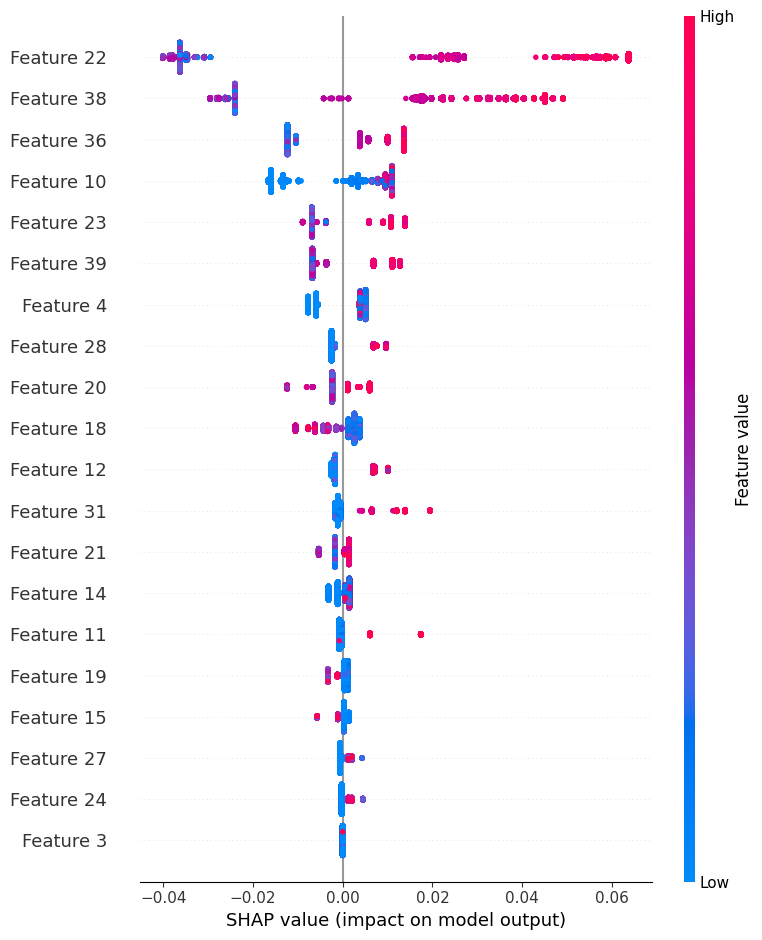

In [21]:
shap.summary_plot(shap_values, X_train)

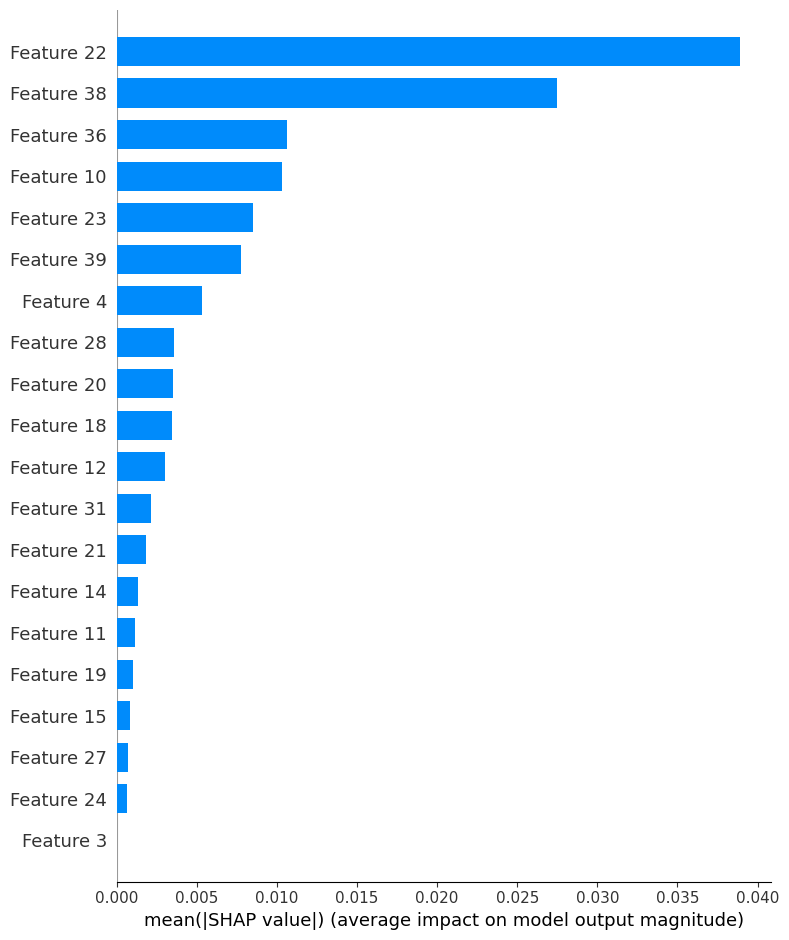

In [22]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [26]:
shap.dependence_plot(0, shap_values, X_train)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations